# 🧠 **Slot Attention Symbolic Extraction – Full Pipeline Explanation**

This notebook runs the **Slot Attention model** on an example ConCon image to extract and visualize **symbolic object attributes per slot**.

---

## 📦 **1. Imports and Setup**

We import libraries for:

- **Image loading and transforms:** PIL, torchvision
- **Computation:** numpy, torch
- **Visualization:** matplotlib, seaborn
- **Optimization:** scipy (Hungarian matching)
- **Model:** Local `SlotAttention_model`


## 🔧 **2. Initialize and Load Model**

We set up the **Slot Attention model** with:

- `n_slots=10` → maximum objects detected
- `n_iters=3` → slot attention iterations
- `n_attr=18` → number of symbolic attributes
- Load pre-trained weights for CLEVR data
- Move to CUDA and set to evaluation mode


In [1]:

from model_nesy import NeSyConceptLearner

import torch
print(torch.cuda.is_available())

from PIL import Image
import torchvision.transforms as T
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.optimize import linear_sum_assignment
from collections import defaultdict
import pandas as pd

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True


In [2]:
from model_nesy import SlotAttention_model

model = SlotAttention_model(
    n_slots=10,
    n_iters=3,
    n_attr=18,
    category_ids= [3, 6, 8, 10, 17],  # attribute group boundaries
    in_channels=3,
    encoder_hidden_channels=64,
    attention_hidden_channels=128,
    device='cuda'
)

# Load weights
checkpoint = torch.load('slot-attention-clevr-state-145', map_location='cuda') #
model.load_state_dict(checkpoint['weights'])
model.to('cuda')  
model.eval()

SlotAttention_model(
  (encoder_cnn): SlotAttention_encoder(
    (network): Sequential(
      (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
      (3): ReLU(inplace=True)
      (4): Conv2d(64, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
      (5): ReLU(inplace=True)
      (6): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (7): ReLU(inplace=True)
    )
  )
  (encoder_pos): SoftPositionEmbed(
    (dense): Linear(in_features=4, out_features=64, bias=True)
  )
  (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (mlp): MLP(
    (network): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=64, out_features=64, bias=True)
    )
  )
  (slot_attention): SlotAttention(
    (project_q): Linear(in_features=64, out_features=64, bias=T

## 🖼️ **3. Define Image Transform and Load Example Image**

- **Transform:** Resize to 128x128 and normalize to `[-1,1]` as model input
- **Load:** Select an example from ConCon dataset and convert to RGB

## 🚀 **4. Forward Pass – Get Slot Outputs**

- Run the image through the model (no gradients needed)
- Outputs shape: `[1, n_slots, n_attr + 1]`
  - The first value per slot is **presence score**
  - Remaining values are **symbolic attribute probabilities**

In [8]:
transform = T.Compose([
    T.Resize((128, 128)),
    T.ToTensor(),  # Converts image to [C,H,W] tensor in [0,1] range
])


# Load image from ConCon test set
img_path = "/workspaces/dataset/case_disjoint_main/test/images/t0/0/img_conf_taskid_0_000002.png"  # update this
# /workspaces/dataset/case_disjoint_main/test/images/t0/1/img_conf_taskid_0_000004.png  ---- have confounder
# /workspaces/dataset/case_disjoint_main/val/images/t0/0/img_conf_taskid_0_000110.png


image = Image.open(img_path).convert('RGB')
input_tensor = transform(image).unsqueeze(0).to('cuda')  # Shape: [1, 3, 128, 128]

input_tensor = (input_tensor - 0.5 ) * 2  # Normalize to [-1, 1] range
# Run through the model
model.eval()
with torch.no_grad():
    output = model(input_tensor)  # [1, n_slots, n_attr+1]

print("Output shape:", output.shape)
print("Presence score per slot:", output[0, :, 0])  # Slot presence
print("Attributes per slot (first one):", output[0, 0, 1:])  # First slot attrs

Output shape: torch.Size([1, 10, 19])
Presence score per slot: tensor([9.9888e-01, 9.9933e-01, 3.2060e-04, 9.0681e-05, 2.4042e-03, 9.9500e-01,
        1.3849e-04, 1.7856e-04, 9.9930e-01, 1.3389e-04], device='cuda:0')
Attributes per slot (first one): tensor([5.7365e-01, 5.7990e-01, 5.4337e-01, 1.5632e-05, 9.9960e-01, 2.0205e-05,
        4.5752e-04, 9.9776e-01, 9.9310e-01, 4.7386e-03, 7.4016e-04, 1.6466e-04,
        1.4473e-03, 3.1586e-04, 1.3342e-04, 9.9342e-01, 1.2861e-04, 6.8185e-04],
       device='cuda:0')


## 🔍 **5. Display Output Overview**

Print:

- The output tensor shape
- Presence score per slot (importance of each slot)
- Attributes of the first slot



Plot the input image for context before examining symbolic slot outputs.

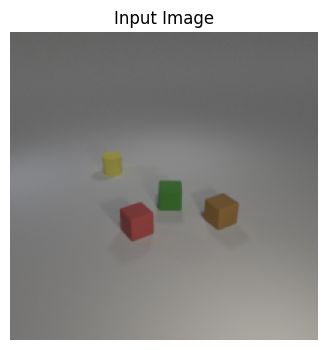

In [4]:
image = Image.open(img_path).convert('RGB')

# Plot the image
plt.figure(figsize=(4, 4))
plt.imshow(image)
plt.title("Input Image")
plt.axis('off')
plt.show()

In [5]:

attr_labels = [
  'pos_x', 'pos_y', 'pos_z',
  'shape_sphere', 'shape_cube', 'shape_cylinder',
  'size_large', 'size_small',          
  'material_rubber', 'material_metal', 
  'color_cyan', 'color_blue', 'color_yellow', 'color_purple',
  'color_red', 'color_green', 'color_gray', 'color_brown'  
]


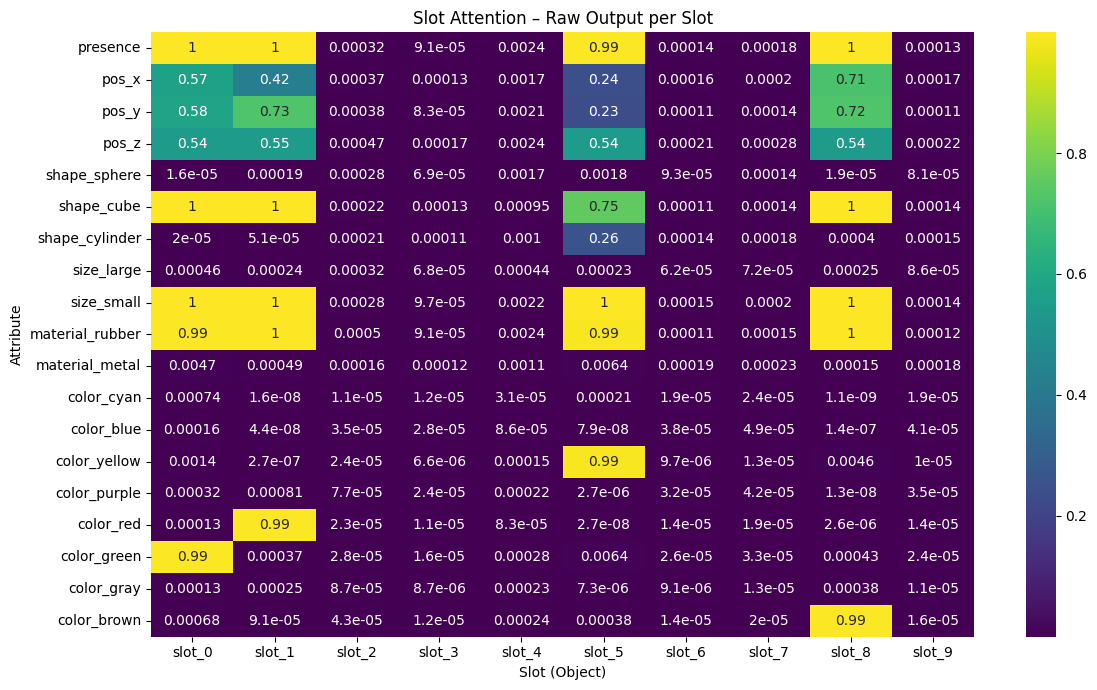

In [10]:
output_tensor = output[0].T.cpu()  # shape: [19, n_slots]


raw_attr_labels = [
  'presence',
  'pos_x', 'pos_y', 'pos_z',
  'shape_sphere', 'shape_cube', 'shape_cylinder',
  'size_large', 'size_small',          
  'material_rubber', 'material_metal', 
  'color_cyan', 'color_blue', 'color_yellow', 'color_purple',
  'color_red', 'color_green', 'color_gray', 'color_brown'  
]


plt.figure(figsize=(12, 7))
sns.heatmap(output_tensor, annot=True, cmap="viridis", cbar=True,
            xticklabels=[f'slot_{i}' for i in range(output_tensor.shape[1])],
            yticklabels=raw_attr_labels)
plt.xlabel("Slot (Object)")
plt.ylabel("Attribute")
plt.title("Slot Attention – Raw Output per Slot")
plt.tight_layout()
plt.show()


## 🧠 **6. Extract Symbolic Attributes**

Uses `model._transform_attrs` to convert model outputs to **symbolic probabilities** for each slot.

---

## 🧼 **7. Clean Symbolic Matrix**

Apply cleaning function to:

- Filter out irrelevant positional attributes
- Remove inactive slots

---

## 📊 **8. Plot Cleaned Symbolic Attributes**

Visualize the cleaned symbolic attribute matrix:

- **Y-axis:** Attribute names
- **X-axis:** Active slots (objects detected)
- Uses a seaborn heatmap for clarity

In [11]:
def clean_symbolic_matrix(symbolic_np, attr_labels):
    """
    symbolic_np : ndarray [n_attr, n_slots] or [n_slots, n_attr] transposed version
    attr_labels : list of str, same length as n_attr

    Returns:
    - cleaned matrix (2D)
    - cleaned attr labels (rows)
    - kept slot indices (columns)
    """
    # If symbolic_np is [n_slots, n_attr] transpose to [n_attr, n_slots]
    if symbolic_np.shape[0] == len(attr_labels):
        mat = symbolic_np.copy()
    else:
        mat = symbolic_np.T.copy()

    # Remove rows where label is pos_x/y/z
    keep_row_mask = [label not in ['pos_x', 'pos_y', 'pos_z'] for label in attr_labels]
    cleaned_mat = mat[keep_row_mask, :]
    cleaned_labels = [label for label, keep in zip(attr_labels, keep_row_mask) if keep]

    # Remove columns (slots) where all values are zero
    active_slot_mask = np.any(cleaned_mat > 0, axis=0)
    final_mat = cleaned_mat[:, active_slot_mask]
    slot_indices = np.where(active_slot_mask)[0]

    return final_mat, cleaned_labels, slot_indices

Symbolic attributes shape: torch.Size([1, 10, 19])
(10, 18) symbolic_np.shape
Cleaned shape: (15, 4)
Kept slots: [0 1 5 8]


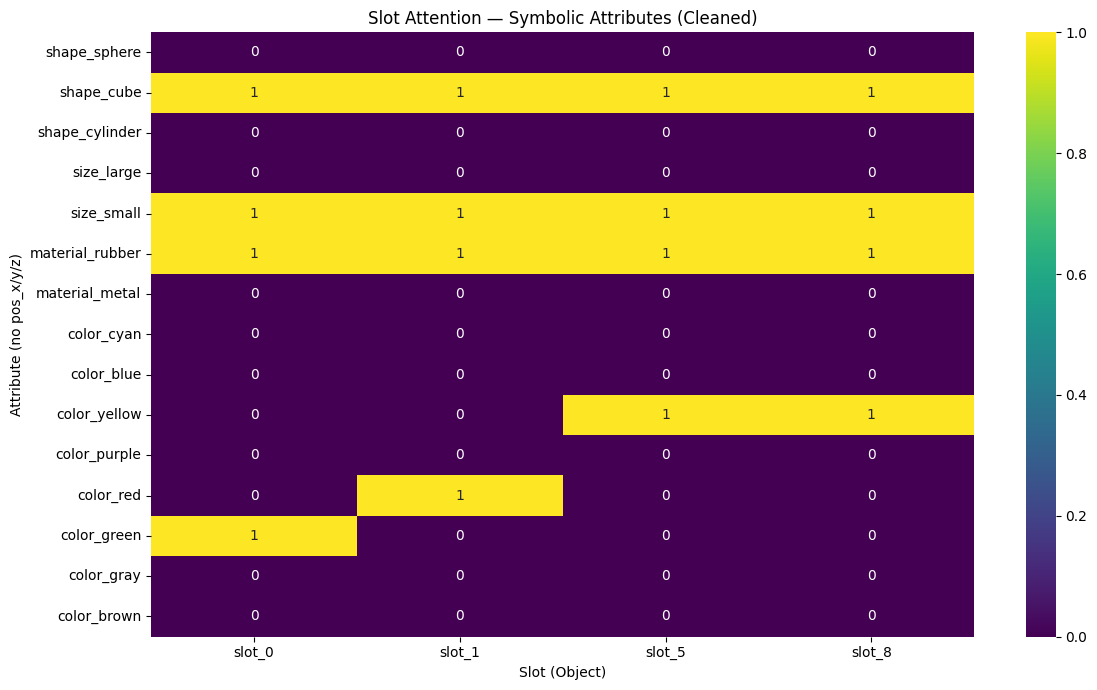

In [12]:


print("Symbolic attributes shape:", output.shape)
# print(output.shape)

# --- APPLY TO YOUR OUTPUT ---
symbolic_attrs = model._transform_attrs(output)  # output must be [1, n_slots, 19]
symbolic_np = symbolic_attrs[0].cpu().numpy()  # shape: [n_slots, n_attr]

print(symbolic_np.shape, "symbolic_np.shape")

# Clean
cleaned_mat, cleaned_labels, slots_kept = clean_symbolic_matrix(symbolic_np, attr_labels)

print("Cleaned shape:", cleaned_mat.shape)
print("Kept slots:", slots_kept)

plt.figure(figsize=(12, 7))
sns.heatmap(cleaned_mat, annot=True, cmap="viridis", cbar=True,
            xticklabels=[f'slot_{i}' for i in slots_kept],
            yticklabels=cleaned_labels)
plt.xlabel("Slot (Object)")
plt.ylabel("Attribute (no pos_x/y/z)")
plt.title("Slot Attention — Symbolic Attributes (Cleaned)")
plt.tight_layout()
plt.show()

In [13]:
print("Cleaned symbolic attributes shape:", cleaned_mat.shape)
print("Cleaned symbolic attributes:", cleaned_mat)
print("Cleaned symbolic attributes labels:", cleaned_labels)

Cleaned symbolic attributes shape: (15, 4)
Cleaned symbolic attributes: [[0. 0. 0. 0.]
 [1. 1. 1. 1.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 1. 1.]
 [0. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
Cleaned symbolic attributes labels: ['shape_sphere', 'shape_cube', 'shape_cylinder', 'size_large', 'size_small', 'material_rubber', 'material_metal', 'color_cyan', 'color_blue', 'color_yellow', 'color_purple', 'color_red', 'color_green', 'color_gray', 'color_brown']


# 🧠 **Slot Attention Continual Confounding Analysis 



## 📦 **1. Initialize Variables and Helper Functions**

Define:

- Dataset **splits** (train, val, test)
- **Tasks** (t0, t1, t2)
- **Cases** (0, 1)
- `match_slots` function to align slots between outputs based on **maximum bipartite matching** (Hungarian algorithm) using symbolic features (shape, size, material, color).

---

## 🔧 **2. Define `process_dataset` Function**

This function:

✅ Iterates over **all tasks, cases, and splits**  
✅ Runs Slot Attention model inference per image  
✅ Cleans symbolic outputs (removing positional attributes, inactive slots)  
✅ Uses `match_slots` to **align slots to a reference image**  
✅ **Accumulates all slot outputs**, pads them to maximum slots per group, and averages them.

### **Return Values:**

- `accumulator`: merged averaged slot matrices per task-case  
- `image_counter`: number of images processed per task-case




In [14]:
import numpy as np

splits = ["train", "val", "test"]
tasks = ["t0", "t1", "t2"]
cases = ["0", "1"]

n_slots = 10
n_attrs = 18

# Store summed symbolic attr counts per group
accumulator = {}
image_counter = {}

# Store all slots for each task/case as a list
slot_pool = defaultdict(list)
image_counter = defaultdict(int)


In [15]:

def match_slots(new_slots, ref_slots, cleaned_labels, threshold=0.5):
    """
    Robust: match slots using multiple groups + reject low similarity pairs.
    """
    group_idx = [
        i for i, lab in enumerate(cleaned_labels)
        if lab.startswith(('shape_', 'size_', 'material_',  'color_'))
    ]

    A = ref_slots[group_idx, :]
    B = new_slots[group_idx, :]

    cost = -np.dot(A.T, B)  # negative similarity

    row_ind, col_ind = linear_sum_assignment(cost)
    similarity = -cost[row_ind, col_ind]  # back to positive

    valid = similarity >= threshold

    # Only accept high-similarity matches
    row_ind = row_ind[valid]
    col_ind = col_ind[valid]

    # Allocate aligned matrix with same slots as ref_slots
    aligned = np.zeros_like(ref_slots)
    aligned[:, row_ind] = new_slots[:, col_ind]

    return aligned

In [16]:
def process_dataset(base_path, model, transform, tasks, cases, splits, attr_labels, match_slots_fn, clean_symbolic_matrix_fn):
    """
    Runs Slot Attention model on a dataset folder structure and returns merged slot results.

    Args:
        base_path (str): dataset root path
        model (torch.nn.Module): your Slot Attention model
        transform (torchvision transform): preprocessing transform
        tasks (list): list of task folder names
        cases (list): list of case folder names
        splits (list): list of dataset splits (train, val, test)
        attr_labels (list): attribute labels
        match_slots_fn (function): slot matching function (e.g. match_slots or match_slots_extend)
        clean_symbolic_matrix_fn (function): cleaning function

    Returns:
        accumulator (dict): averaged slot matrices per task-case
        image_counter (dict): number of images processed per task-case
    """

    slot_pool = defaultdict(list)
    image_counter = defaultdict(int)
    accumulator = {}

    with torch.no_grad():
        for split in splits:
            for task in tasks:
                for case in cases:
                    folder = os.path.join(base_path, split, "images", task, case)
                    if not os.path.exists(folder):
                        continue

                    files = [f for f in os.listdir(folder) if f.endswith(".png")]
                    print(f"📂 Scanning {folder} — {len(files)} images")

                    key = f"{task}_{case}"
                    ref_slots = None

                    for f in files:
                        path = os.path.join(folder, f)
                        img = Image.open(path).convert("RGB")
                        tensor = transform(img).unsqueeze(0).to("cuda")
                        tensor = (tensor - 0.5) * 2

                        output = model(tensor)
                        symbolic = model._transform_attrs(output)[0].cpu().numpy()

                        cleaned, cleaned_labels, slots_kept = clean_symbolic_matrix_fn(symbolic, attr_labels)

                        if ref_slots is None:
                            ref_slots = cleaned.copy()
                            slot_pool[key].append(ref_slots)
                        else:
                            aligned = match_slots_fn(cleaned, ref_slots, cleaned_labels)
                            slot_pool[key].append(aligned)

                        image_counter[key] += 1

    # ✅ 3️⃣ Merge slots (pad and average)
    for key, slots_list in slot_pool.items():
        max_slots = max(s.shape[1] for s in slots_list)
        padded = []
        for s in slots_list:
            if s.shape[1] < max_slots:
                pad = np.zeros((s.shape[0], max_slots - s.shape[1]))
                s = np.concatenate([s, pad], axis=1)
            padded.append(s)

        stacked = np.stack(padded, axis=0)  # [N, n_attr, max_slots]
        mean_slots = np.mean(stacked, axis=0)
        accumulator[key] = mean_slots

        print(f"✅ Merged: {key} — final slots: {mean_slots.shape[1]}, images: {image_counter[key]}")

    return accumulator, image_counter

In [17]:
attr_labels = [
  'pos_x', 'pos_y', 'pos_z',
  'shape_sphere', 'shape_cube', 'shape_cylinder',
  'size_large', 'size_small',          
  'material_rubber', 'material_metal', 
  'color_cyan', 'color_blue', 'color_yellow', 'color_purple',
  'color_red', 'color_green', 'color_gray', 'color_brown'  
]

accumulator, image_counter = process_dataset(
    base_path="/workspaces/dataset/case_disjoint_main",
    model=model,
    transform=transform,
    tasks=["t0", "t1", "t2"],
    cases=["0", "1"],
    splits=["train", "val", "test"],
    attr_labels=attr_labels,
    match_slots_fn=match_slots,  # or match_slots_extend for dynamic slots
    clean_symbolic_matrix_fn=clean_symbolic_matrix
)


📂 Scanning /workspaces/dataset/case_disjoint_main/train/images/t0/0 — 3000 images
📂 Scanning /workspaces/dataset/case_disjoint_main/train/images/t0/1 — 3000 images
📂 Scanning /workspaces/dataset/case_disjoint_main/train/images/t1/0 — 3000 images
📂 Scanning /workspaces/dataset/case_disjoint_main/train/images/t1/1 — 3000 images
📂 Scanning /workspaces/dataset/case_disjoint_main/train/images/t2/0 — 3000 images
📂 Scanning /workspaces/dataset/case_disjoint_main/train/images/t2/1 — 3000 images
📂 Scanning /workspaces/dataset/case_disjoint_main/val/images/t0/0 — 750 images
📂 Scanning /workspaces/dataset/case_disjoint_main/val/images/t0/1 — 750 images
📂 Scanning /workspaces/dataset/case_disjoint_main/val/images/t1/0 — 750 images
📂 Scanning /workspaces/dataset/case_disjoint_main/val/images/t1/1 — 750 images
📂 Scanning /workspaces/dataset/case_disjoint_main/val/images/t2/0 — 750 images
📂 Scanning /workspaces/dataset/case_disjoint_main/val/images/t2/1 — 750 images
📂 Scanning /workspaces/dataset/cas

In [18]:
clean_attr_labels = [
  'shape_sphere', 'shape_cube', 'shape_cylinder',
  'size_large', 'size_small',          
  'material_rubber', 'material_metal', 
  'color_cyan', 'color_blue', 'color_yellow', 'color_purple',
  'color_red', 'color_green', 'color_gray', 'color_brown'  
]

## Disjoint case

## 📊 **4. Visualize Merged Slot Outputs per Task-Case**

For each **task**:

- Plot heatmaps of **case 0 vs case 1** merged outputs side by side.
- Shows how symbolic attributes differ between confounded (case 1) and unconfounded (case 0) images.



---

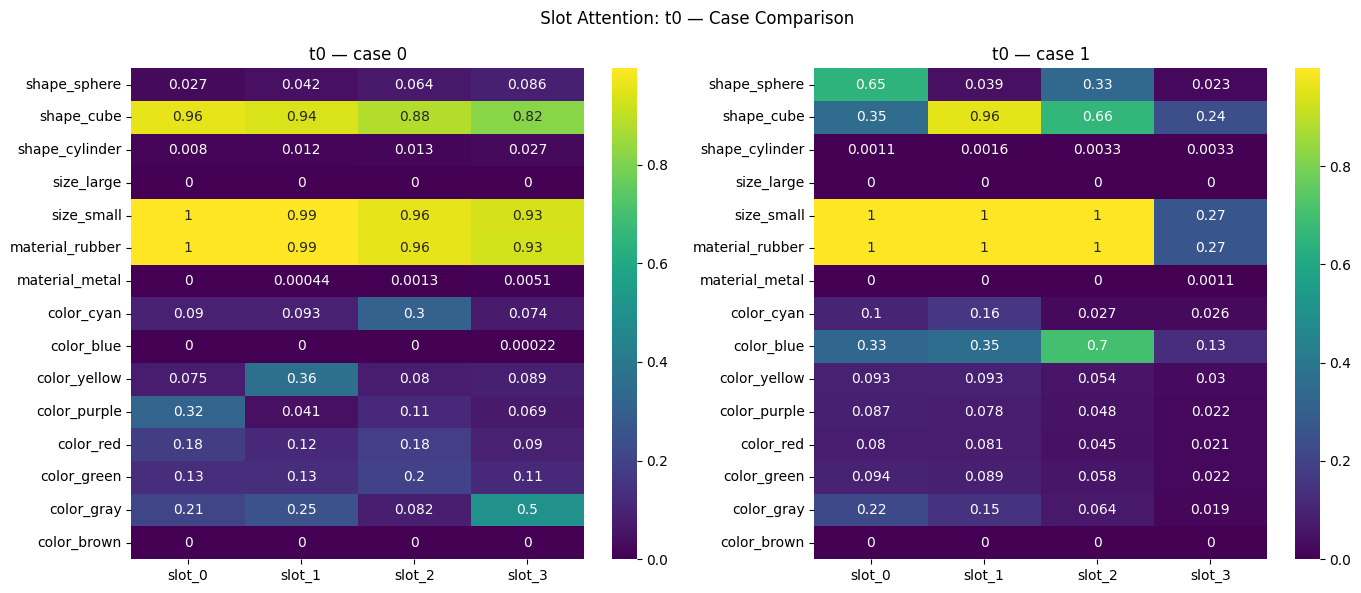

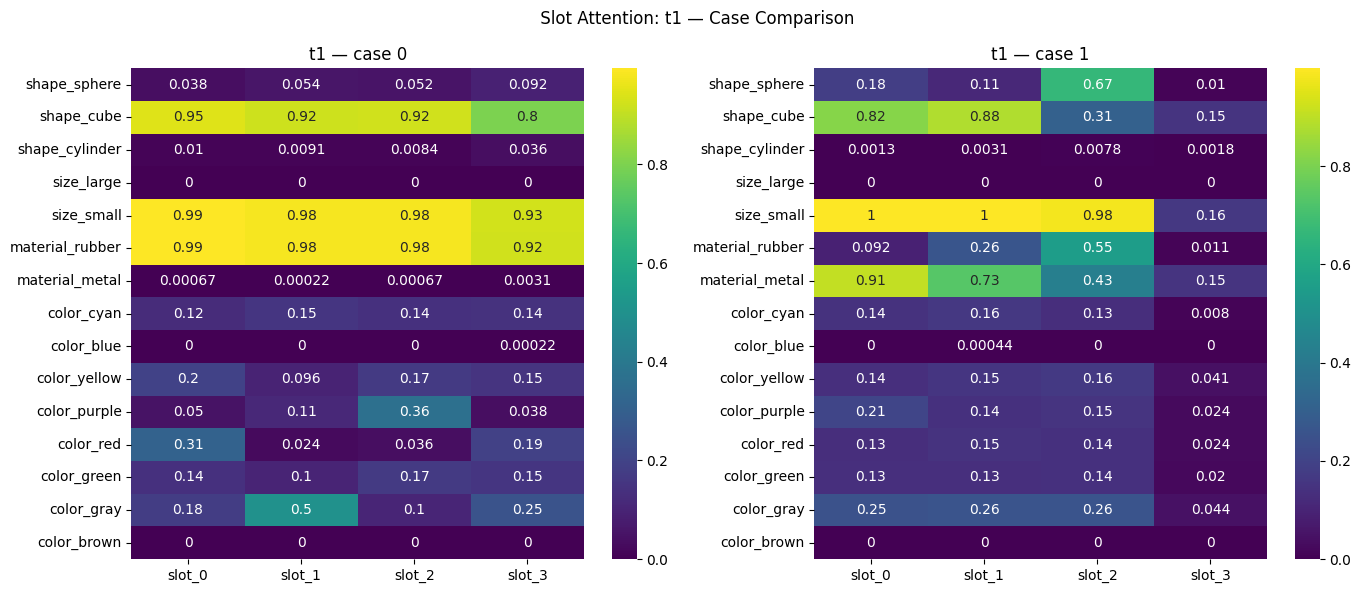

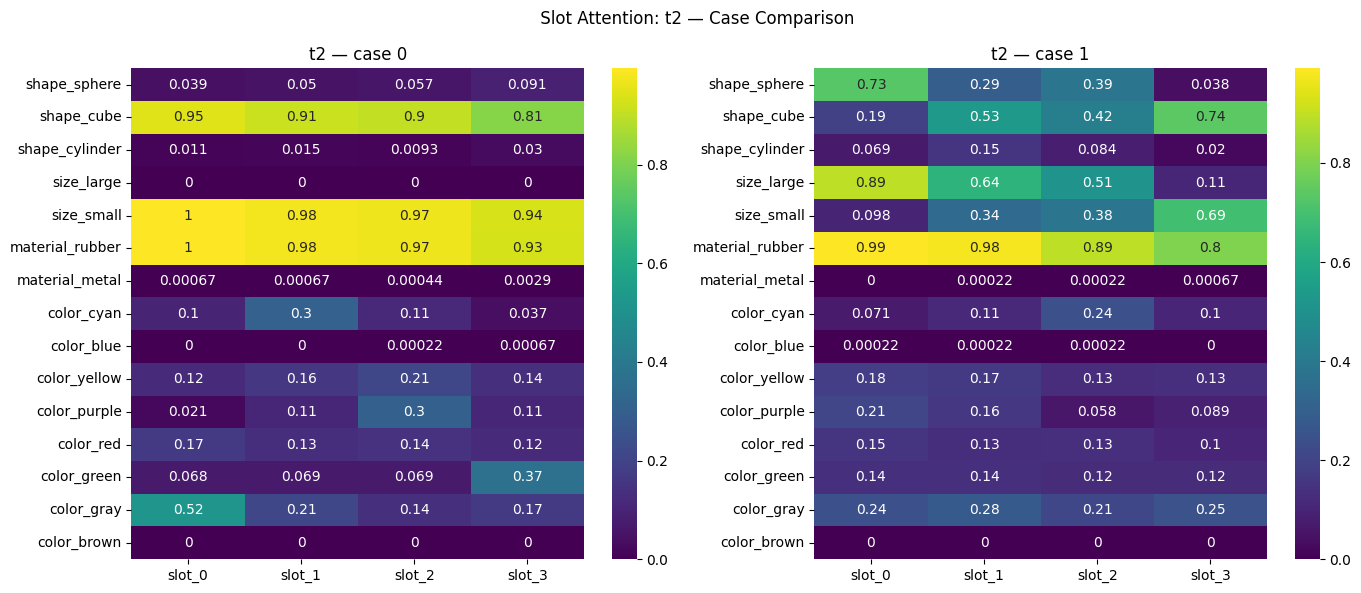

In [19]:

for task in tasks:
    plt.figure(figsize=(14, 6))

    for i, case in enumerate(cases):
        key = f"{task}_{case}"
        merged = accumulator[key]  # [n_attr, n_slots]

        plt.subplot(1, len(cases), i+1)
        sns.heatmap(merged, cmap="viridis", annot=True, cbar=True,
                    xticklabels=[f"slot_{i}" for i in range(merged.shape[1])],
                    yticklabels=clean_attr_labels)
        plt.title(f"{task} — case {case}")

    plt.suptitle(f" Slot Attention: {task} — Case Comparison")
    plt.tight_layout()
    plt.show()


## 🔍 **5. Difference Analysis: Case1 - Case0**

For each task:

- Compute and plot **difference heatmaps** (case1 - case0).  
- Highlights attributes where confounders cause notable differences in slot representations.

---



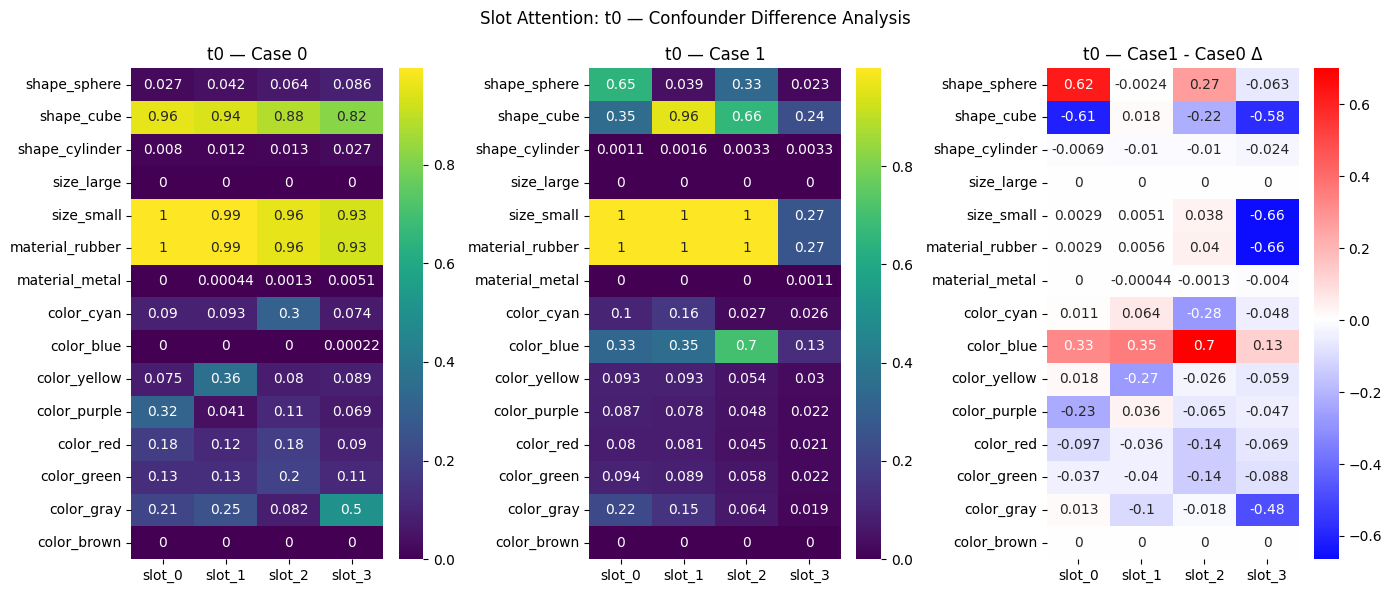

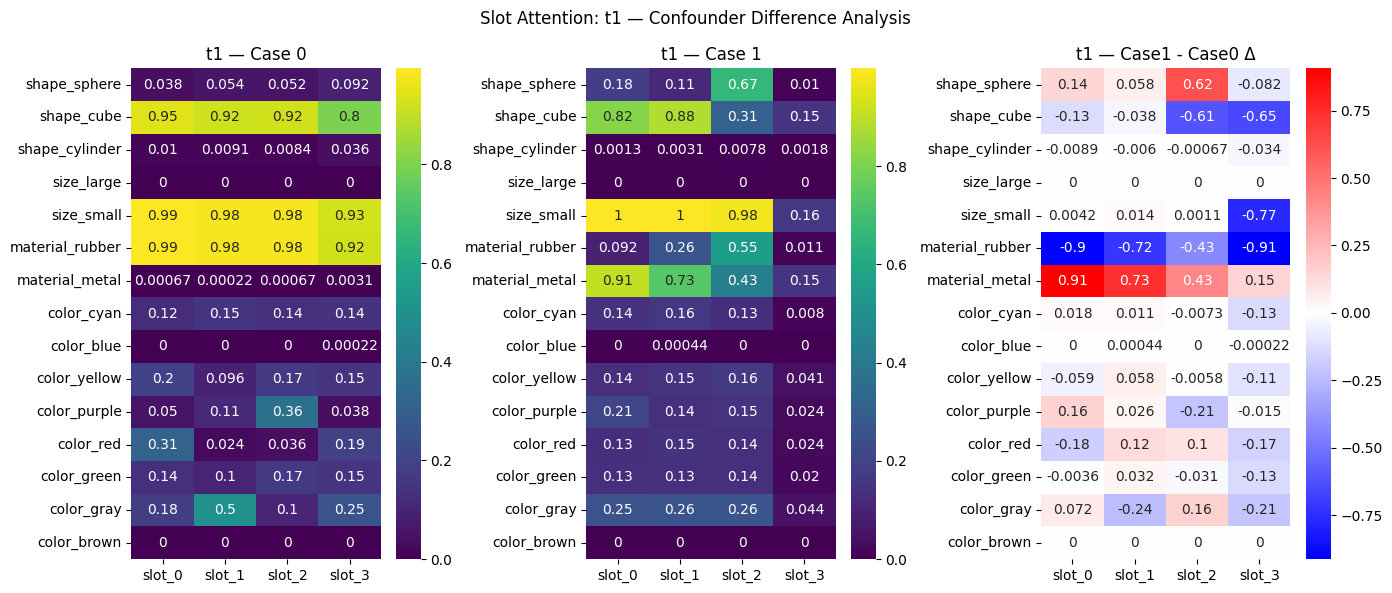

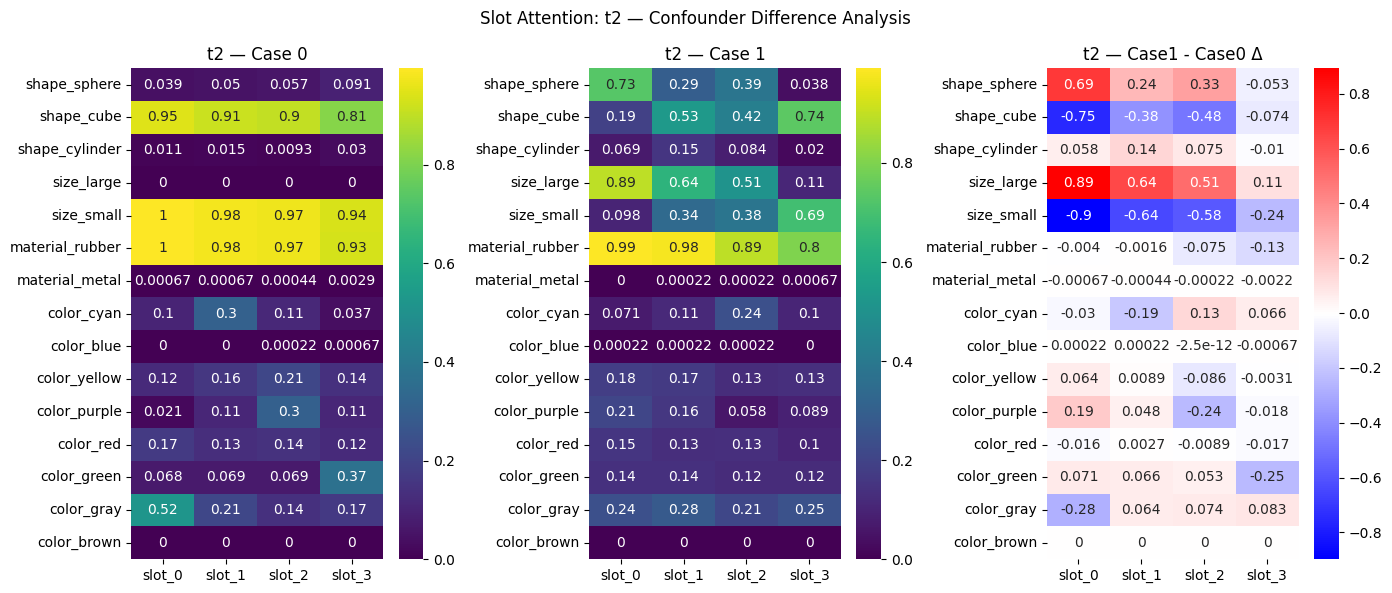

In [20]:

# Loop through each task to compare case 1 vs case 0
for task in tasks:
    key_0 = f"{task}_0"
    key_1 = f"{task}_1"

    # Retrieve merged aligned slots for each case
    merged_0 = accumulator[key_0]  # [n_attr, n_slots]
    merged_1 = accumulator[key_1]

    # Compute difference: case1 - case0
    diff = merged_1 - merged_0

    plt.figure(figsize=(14, 6))

    # 🔹 Subplot 1: case 0
    plt.subplot(1, 3, 1)
    sns.heatmap(merged_0, cmap="viridis", annot=True, cbar=True,
                xticklabels=[f"slot_{i}" for i in range(merged_0.shape[1])],
                yticklabels=clean_attr_labels)
    plt.title(f"{task} — Case 0")

    # 🔹 Subplot 2: case 1
    plt.subplot(1, 3, 2)
    sns.heatmap(merged_1, cmap="viridis", annot=True, cbar=True,
                xticklabels=[f"slot_{i}" for i in range(merged_1.shape[1])],
                yticklabels=clean_attr_labels)
    plt.title(f"{task} — Case 1")

    # 🔹 Subplot 3: difference heatmap
    plt.subplot(1, 3, 3)
    sns.heatmap(diff, cmap="bwr", center=0, annot=True, cbar=True,
                xticklabels=[f"slot_{i}" for i in range(diff.shape[1])],
                yticklabels=clean_attr_labels)
    plt.title(f"{task} — Case1 - Case0 Δ")

    plt.suptitle(f"Slot Attention: {task} — Confounder Difference Analysis")
    plt.tight_layout()
    plt.show()
    


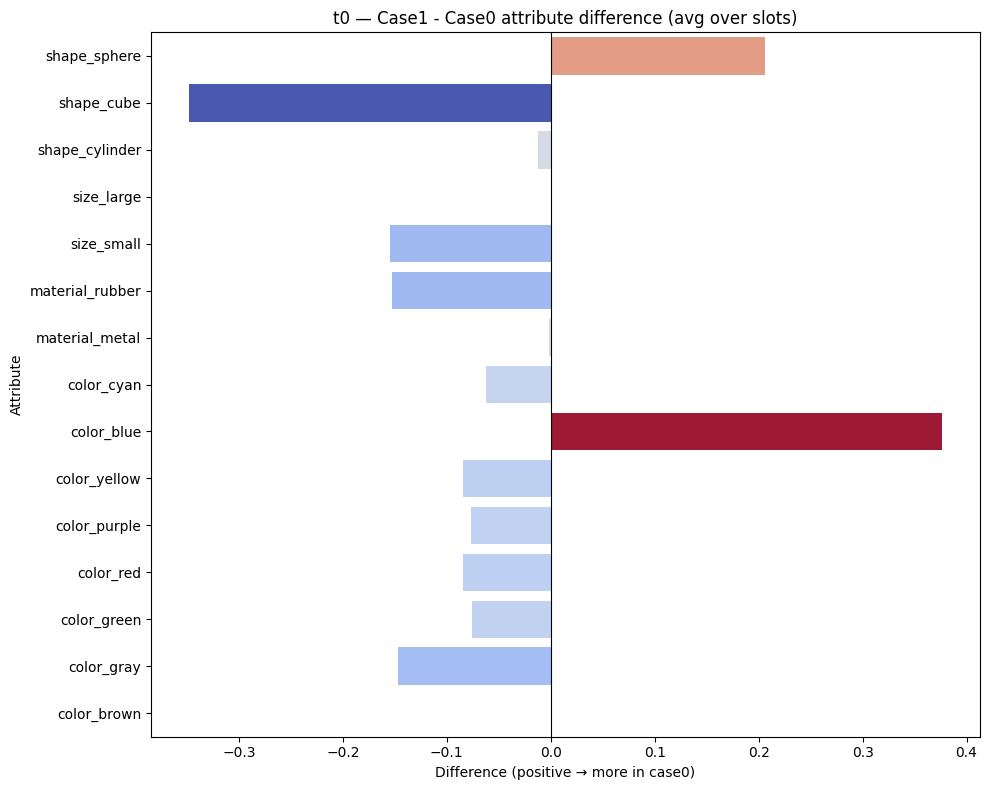

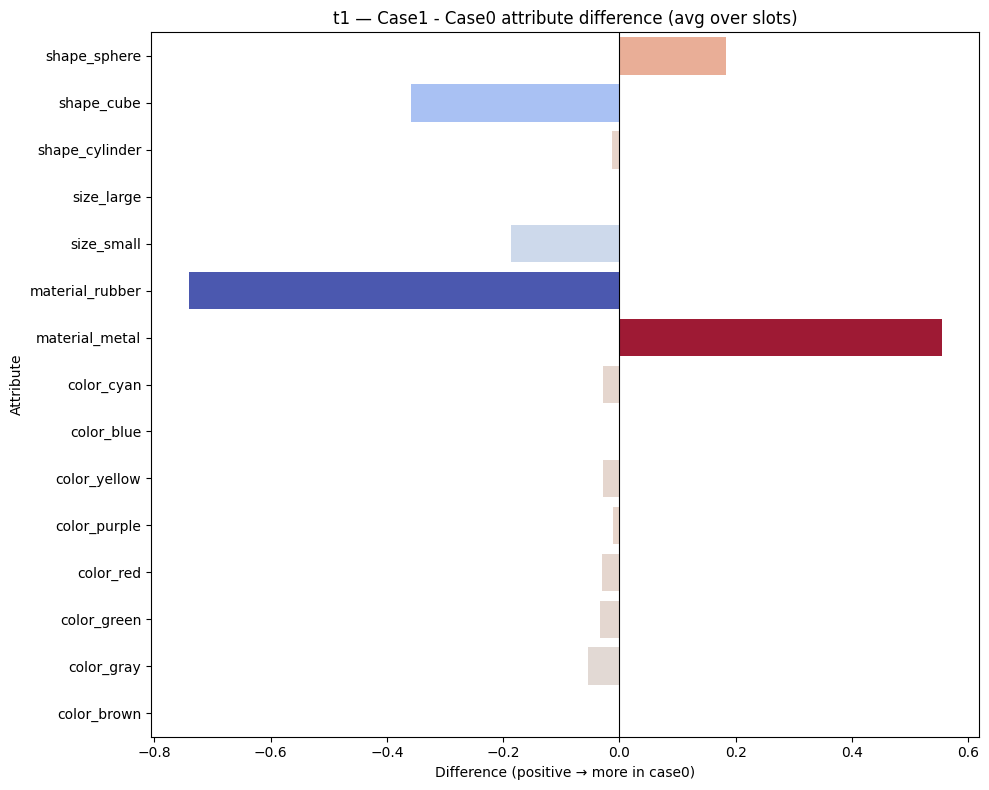

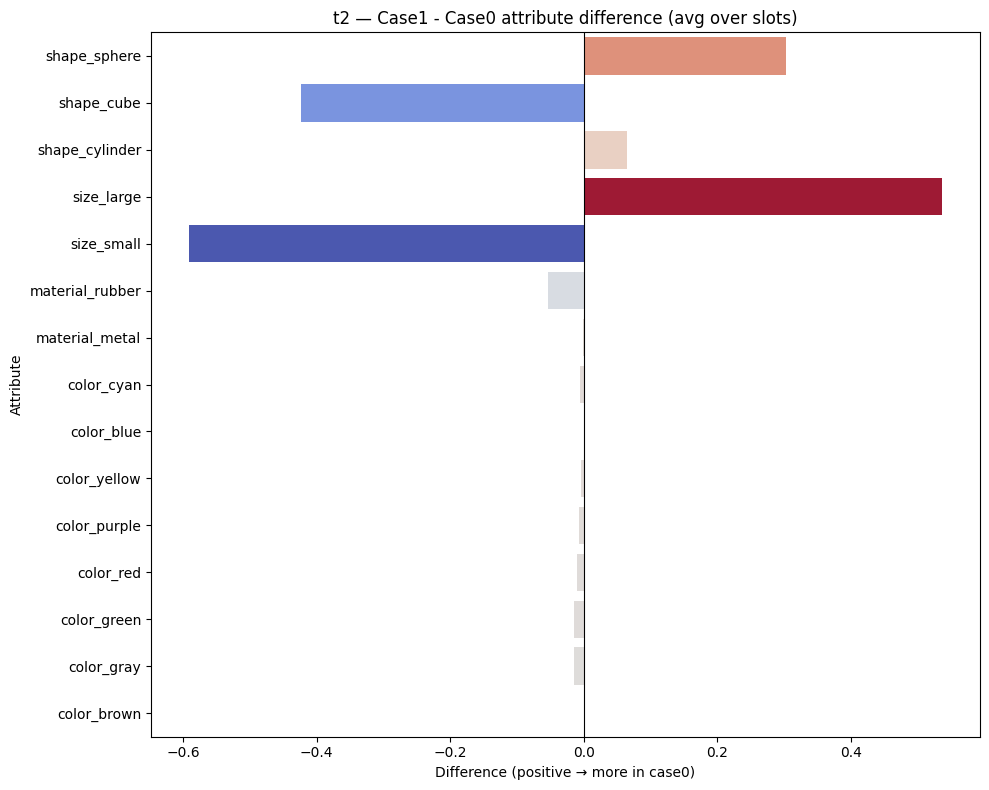

In [21]:
# Loop through each task to compare case 1 vs case 0 (averaging over slots first)
for task in tasks:
    key_0 = f"{task}_0"
    key_1 = f"{task}_1"

    # Retrieve merged aligned slots for each case
    merged_0 = accumulator[key_0]  # [n_attr, n_slots]
    merged_1 = accumulator[key_1]

    # 🔹 Average over slots to get [n_attr] vector
    mean_0 = merged_0.mean(axis=1)
    mean_1 = merged_1.mean(axis=1)

    # Compute difference: case1 - case0
    diff = mean_1 - mean_0

    # Build DataFrame for plotting
    df_diff = pd.DataFrame({
        'Attribute': clean_attr_labels,
        'Difference': diff
    })

    plt.figure(figsize=(10, 8))
    sns.barplot(data=df_diff, x='Difference', y='Attribute', hue='Difference', palette="coolwarm", dodge=False)
    plt.title(f"{task} — Case1 - Case0 attribute difference (avg over slots)")
    plt.xlabel("Difference (positive → more in case0)")
    plt.ylabel("Attribute")
    plt.axvline(0, color="black", linewidth=0.8)
    plt.legend([],[], frameon=False)  # remove legend if not needed
    plt.tight_layout()
    plt.show()


## 🔗 **6. Combine Case0 and Case1 per Task**

For each task:

- Combine slots across **case0 and case1** (e.g. average).  
- Store in `task_combined` for cross-task comparison.



# Cross-Task Comparison**

Plot combined outputs per task to compare **object representations across tasks**:

✅ Shows how different tasks learn to represent objects in symbolic slots even when confounders vary.


## ⚡ **7. Cross-Task Difference Analysis**

For selected **task pairs (t1-t0, t2-t0, t2-t1)**:

- Compute **difference heatmaps** between tasks.  
- Uses diverging colormap centered at 0 to highlight positive/negative differences.

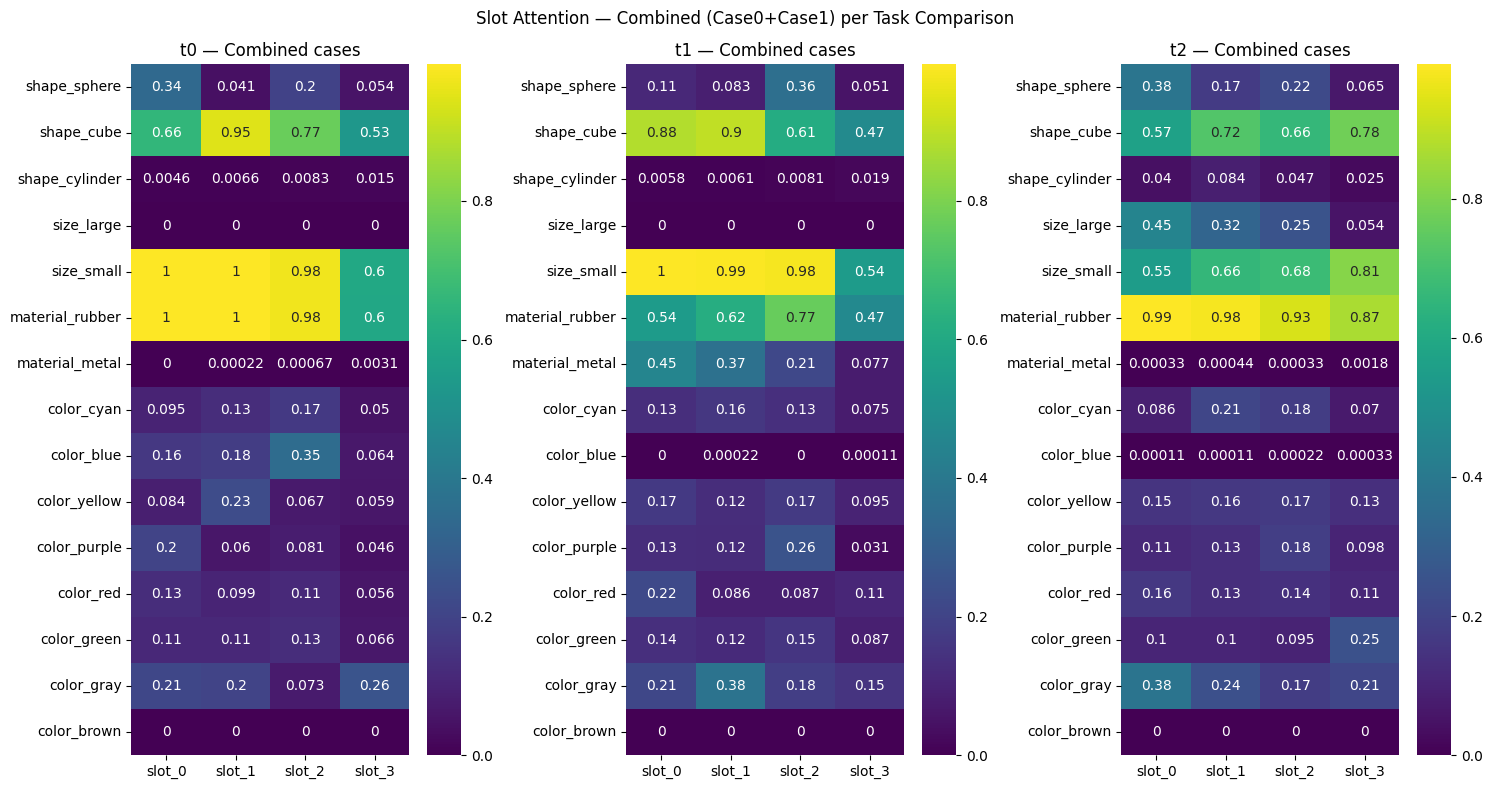

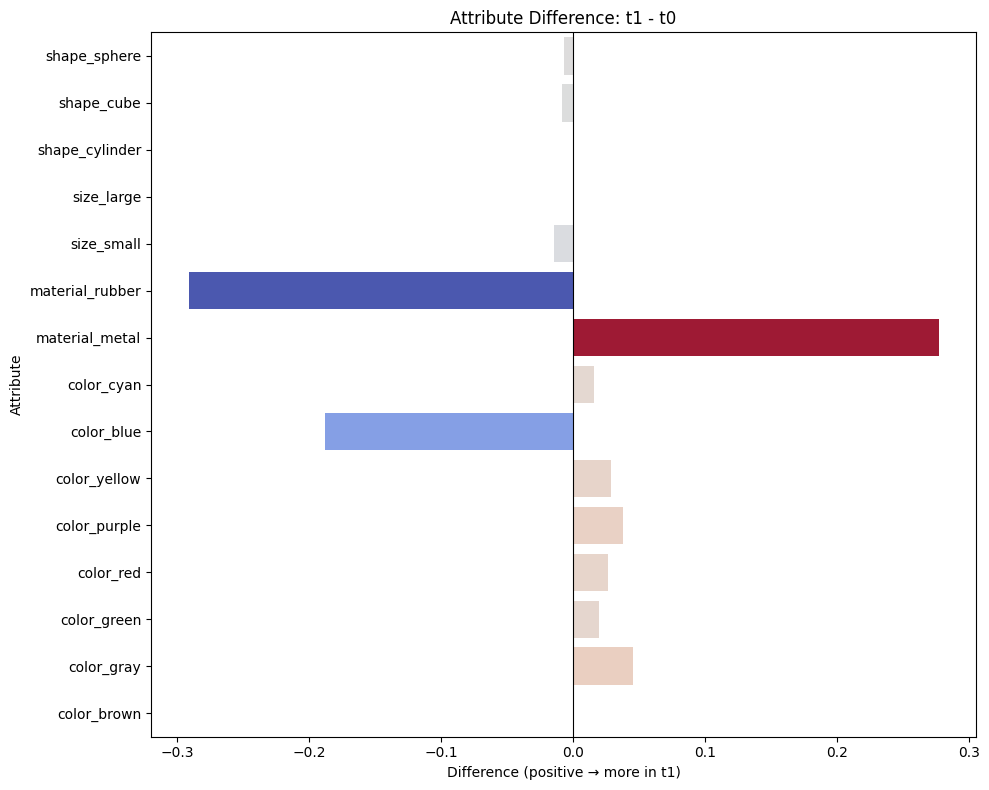

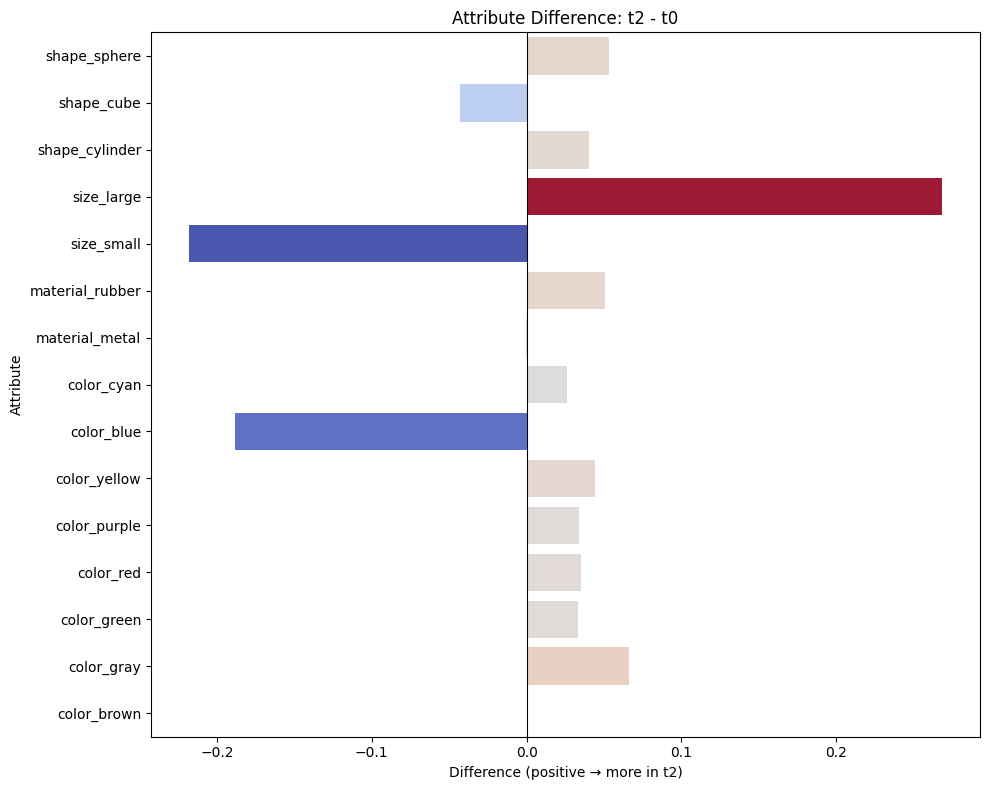

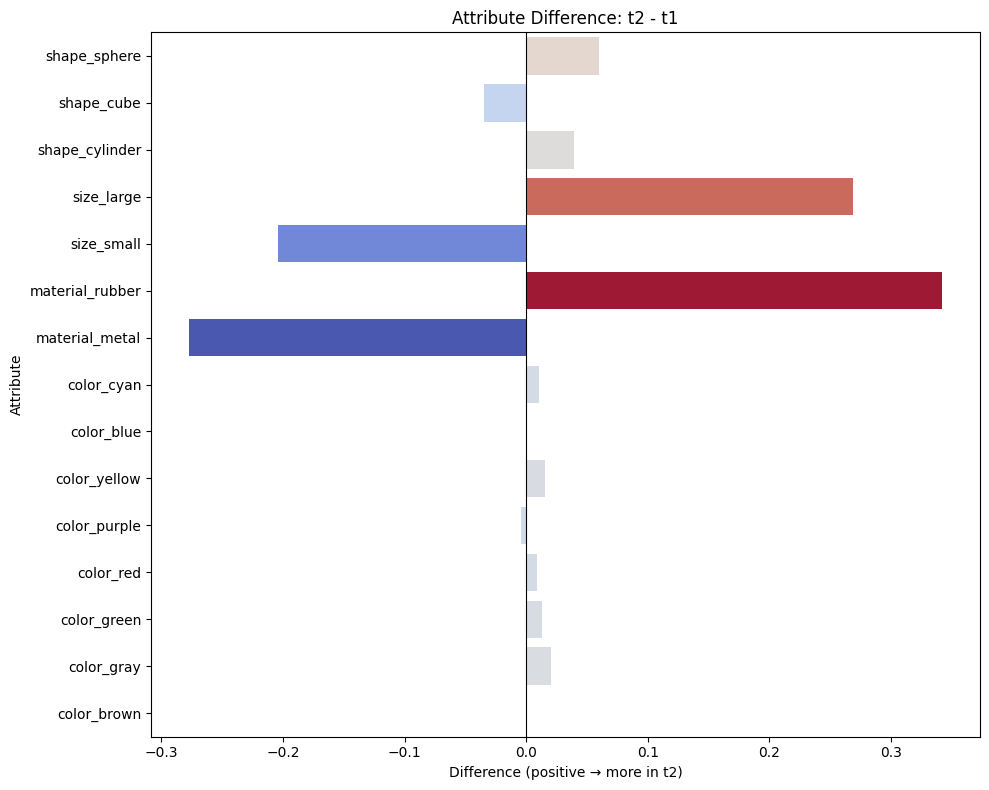

In [22]:
# First combine (case0 + case1) per task
task_combined = {}

for task in tasks:
    key_0 = f"{task}_0"
    key_1 = f"{task}_1"

    merged_0 = accumulator[key_0]
    merged_1 = accumulator[key_1]

    # ✅ Combine via average or sum (choose your method)
    combined = (merged_0 + merged_1) / 2
    task_combined[task] = combined

# ✅ Now compare across tasks
num_tasks = len(tasks)
plt.figure(figsize=(5 * num_tasks, 8))

for i, task in enumerate(tasks):
    combined = task_combined[task]

    plt.subplot(1, num_tasks, i+1)
    sns.heatmap(combined, cmap="viridis", annot=True, cbar=True,
                xticklabels=[f"slot_{j}" for j in range(combined.shape[1])],
                yticklabels=clean_attr_labels)
    plt.title(f"{task} — Combined cases")

plt.suptitle("Slot Attention — Combined (Case0+Case1) per Task Comparison")
plt.tight_layout()
plt.show()


task_pairs = [("t1", "t0"), ("t2", "t0"), ("t2", "t1")]

for (task_a, task_b) in task_pairs:
    # 🔹 Average over slots per task
    mean_a = task_combined[task_a].mean(axis=1)  # [n_attr]
    mean_b = task_combined[task_b].mean(axis=1)

    diff = mean_a - mean_b

    # 🔹 Build dataframe for plotting
    df_diff = pd.DataFrame({
        'Attribute': clean_attr_labels,
        'Difference': diff
    })

    plt.figure(figsize=(10, 8))
    sns.barplot(data=df_diff, x='Difference', y='Attribute',
                palette="coolwarm", hue='Difference' , dodge=False)
    plt.title(f"Attribute Difference: {task_a} - {task_b}")
    plt.xlabel(f"Difference (positive → more in {task_a})")
    plt.ylabel("Attribute")
    plt.axvline(0, color='black', linewidth=0.8)
    plt.legend([],[], frameon=False)  # Remove redundant legend
    plt.tight_layout()
    plt.show()

## 📊 **8. Attribute Distribution Across Tasks**

This section:

- **Sums attribute activations** per task
- Builds a dataframe to compare tasks
- **Normalizes** to show each attribute’s fraction per task

### ✅ **Plot: Stacked Bar Chart**

- **X-axis:** Attributes  
- **Y-axis:** Fraction per attribute (stacked by task)

**Purpose:**  
Quickly visualize how tasks differ in symbolic attribute usage and detect possible confounding.

---


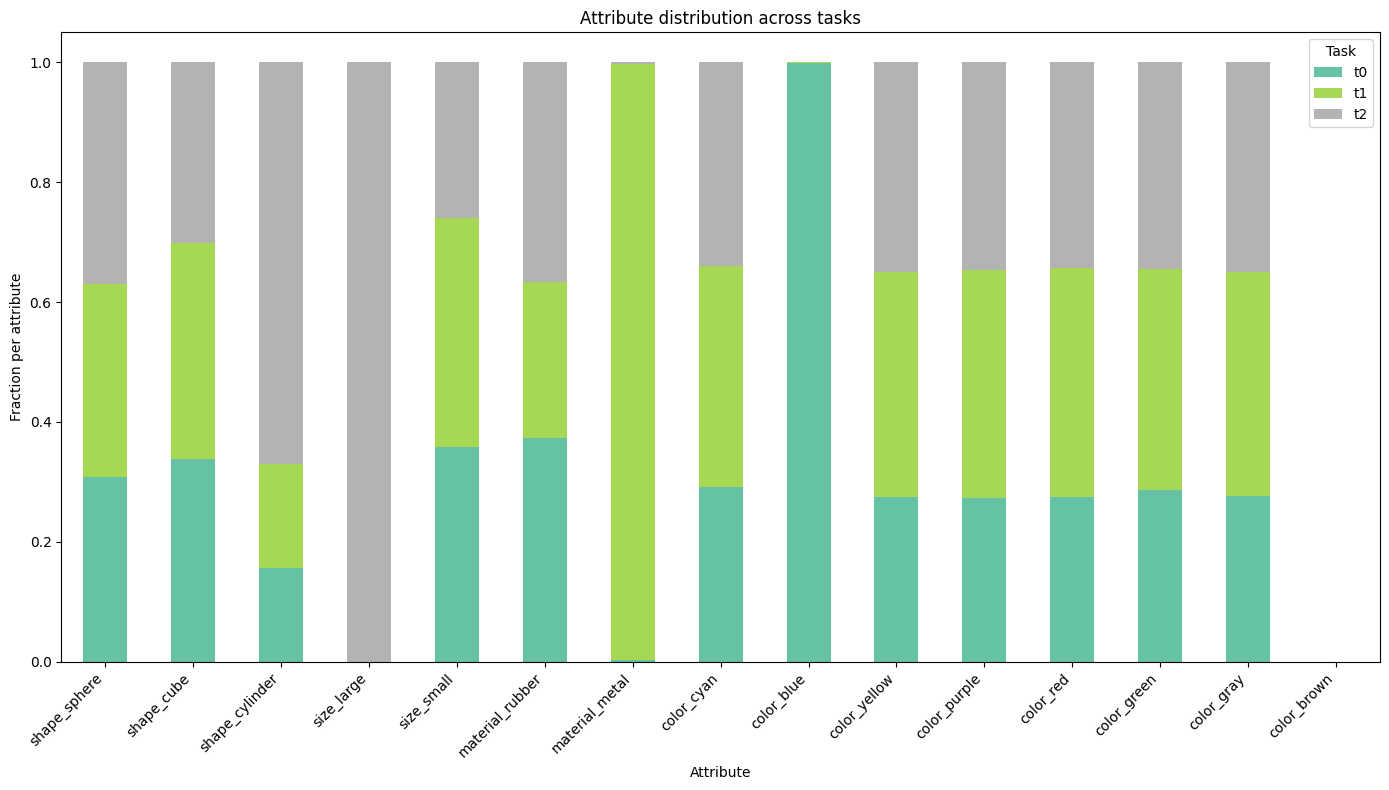

In [20]:


# Build dataframe
task_sums = {}
for task in tasks:
    combined = task_combined[task]
    attr_sum = combined.sum(axis=1)
    task_sums[task] = attr_sum

df = pd.DataFrame(task_sums, index=clean_attr_labels)

# Normalize to fraction per attribute if desired
df_norm = df.div(df.sum(axis=1), axis=0)

# Plot
df_norm.plot(kind="bar", stacked=True, figsize=(14,8), colormap="Set2")
plt.title("Attribute distribution across tasks")
plt.ylabel("Fraction per attribute")
plt.xlabel("Attribute")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Task")
plt.tight_layout()
plt.show()


In [34]:
strict_accumulator, strict_image_counter = process_dataset(
    base_path="/workspaces/dataset/case_strict_main",
    model=model,
    transform=transform,
    tasks=["t0", "t1", "t2"],
    cases=["0", "1"],
    splits=["train", "val", "test"],
    attr_labels=attr_labels,
    match_slots_fn=match_slots,  # or match_slots_extend for dynamic slots
    clean_symbolic_matrix_fn=clean_symbolic_matrix
)


📂 Scanning /workspaces/dataset/case_strict_main/train/images/t0/0 — 3000 images
📂 Scanning /workspaces/dataset/case_strict_main/train/images/t0/1 — 3000 images
📂 Scanning /workspaces/dataset/case_strict_main/train/images/t1/0 — 3000 images
📂 Scanning /workspaces/dataset/case_strict_main/train/images/t1/1 — 3000 images
📂 Scanning /workspaces/dataset/case_strict_main/train/images/t2/0 — 3000 images
📂 Scanning /workspaces/dataset/case_strict_main/train/images/t2/1 — 3000 images
📂 Scanning /workspaces/dataset/case_strict_main/val/images/t0/0 — 750 images
📂 Scanning /workspaces/dataset/case_strict_main/val/images/t0/1 — 750 images
📂 Scanning /workspaces/dataset/case_strict_main/val/images/t1/0 — 750 images
📂 Scanning /workspaces/dataset/case_strict_main/val/images/t1/1 — 750 images
📂 Scanning /workspaces/dataset/case_strict_main/val/images/t2/0 — 750 images
📂 Scanning /workspaces/dataset/case_strict_main/val/images/t2/1 — 750 images
📂 Scanning /workspaces/dataset/case_strict_main/test/image

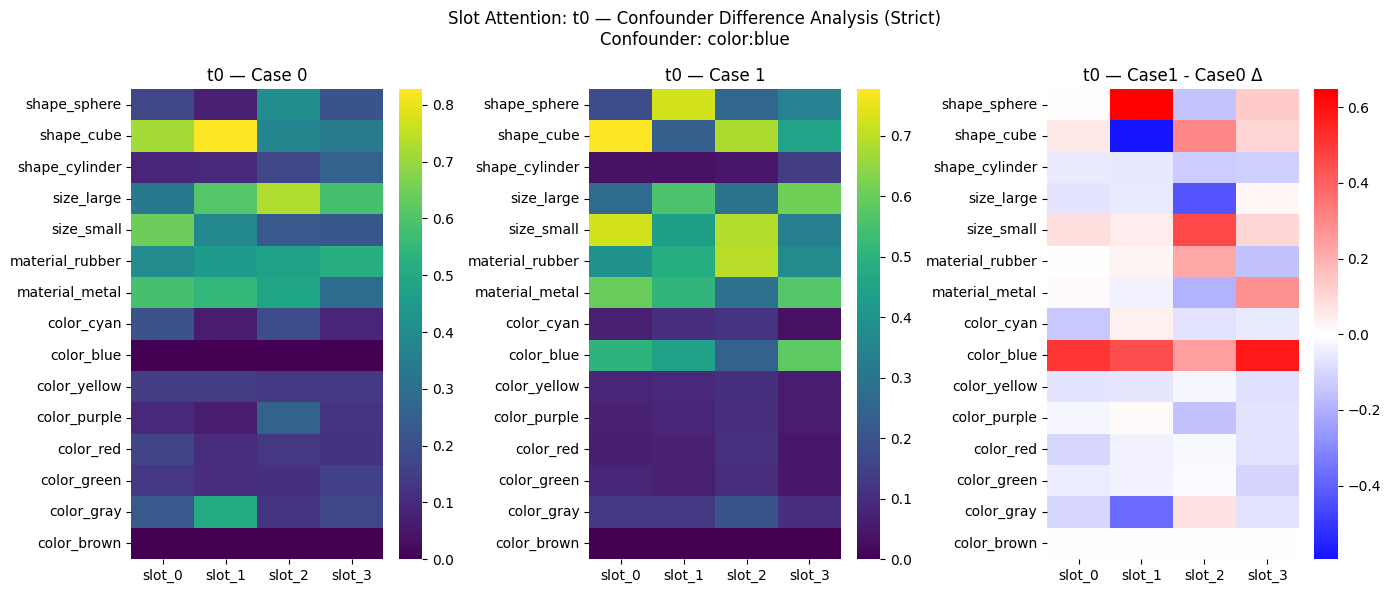

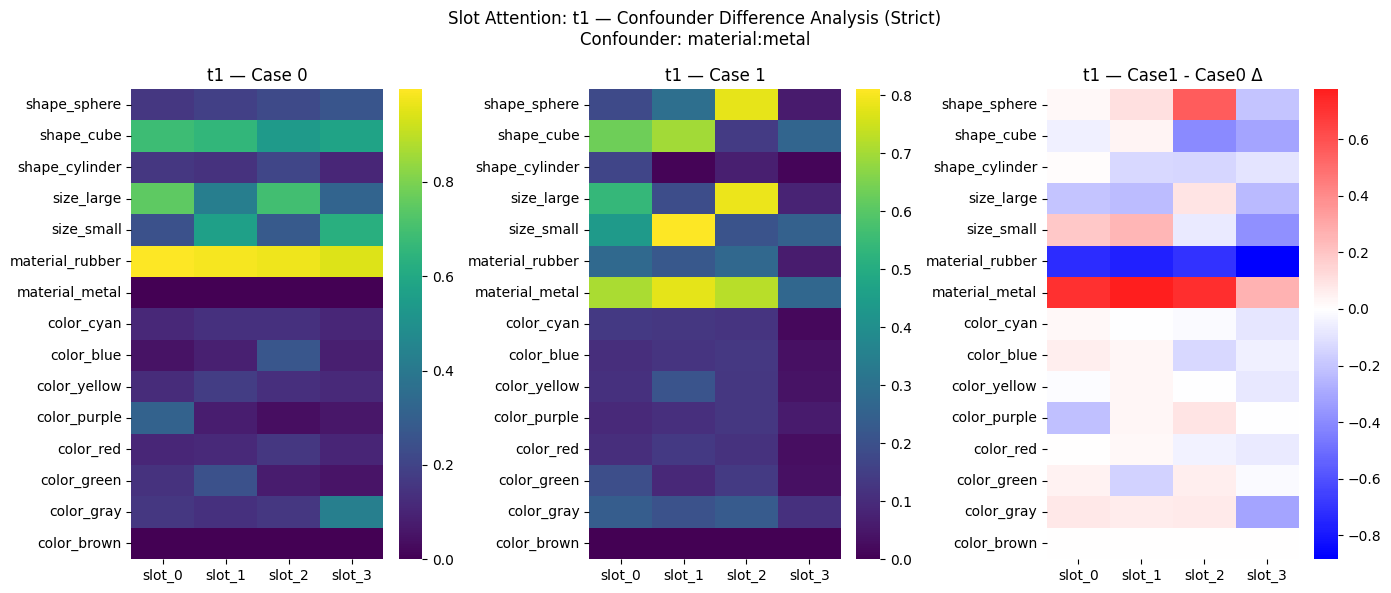

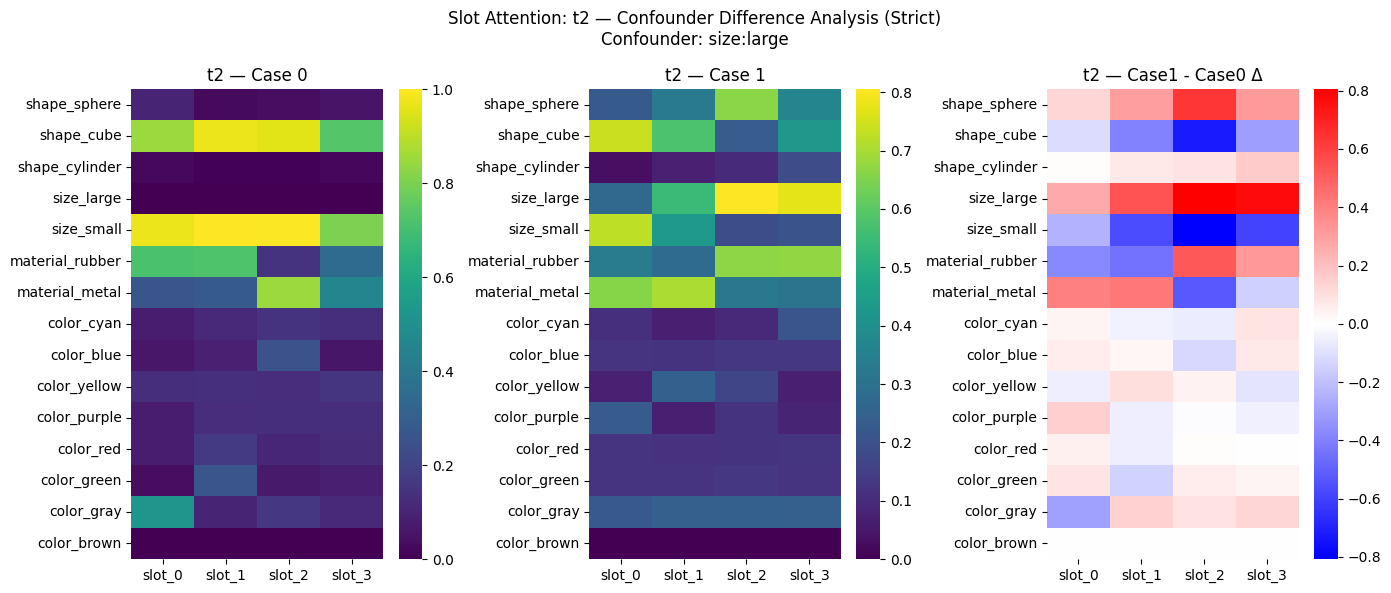

In [35]:
# Define confounder info dict
confounders = {
  "0": {"shape": "", "size": "", "material": "", "color": "blue"},
  "1": {"shape": "", "size": "", "material": "metal", "color": ""},
  "2": {"shape": "", "size": "large", "material": "", "color": ""}
}

# Loop through each task to compare case 1 vs case 0
for task in tasks:
    key_0 = f"{task}_0"
    key_1 = f"{task}_1"

    # Retrieve merged aligned slots for each case
    merged_0 = strict_accumulator[key_0]  # [n_attr, n_slots]
    merged_1 = strict_accumulator[key_1]

    # Compute difference: case1 - case0
    diff = merged_1 - merged_0

    # Get confounder info for this task
    conf = confounders[task[-1]]  # extract task index as string
    conf_str = ", ".join([f"{k}:{v}" for k,v in conf.items() if v != ""])
    if not conf_str:
        conf_str = "None"

    plt.figure(figsize=(14, 6))

    # 🔹 Subplot 1: case 0
    plt.subplot(1, 3, 1)
    sns.heatmap(merged_0, cmap="viridis", annot=False, cbar=True,
                xticklabels=[f"slot_{i}" for i in range(merged_0.shape[1])],
                yticklabels=clean_attr_labels)
    plt.title(f"{task} — Case 0")

    # 🔹 Subplot 2: case 1
    plt.subplot(1, 3, 2)
    sns.heatmap(merged_1, cmap="viridis", annot=False, cbar=True,
                xticklabels=[f"slot_{i}" for i in range(merged_1.shape[1])],
                yticklabels=clean_attr_labels)
    plt.title(f"{task} — Case 1")

    # 🔹 Subplot 3: difference heatmap
    plt.subplot(1, 3, 3)
    sns.heatmap(diff, cmap="bwr", center=0, annot=False, cbar=True,
                xticklabels=[f"slot_{i}" for i in range(diff.shape[1])],
                yticklabels=clean_attr_labels)
    plt.title(f"{task} — Case1 - Case0 Δ")

    plt.suptitle(f"Slot Attention: {task} — Confounder Difference Analysis (Strict)\nConfounder: {conf_str}")
    plt.tight_layout()
    plt.show()


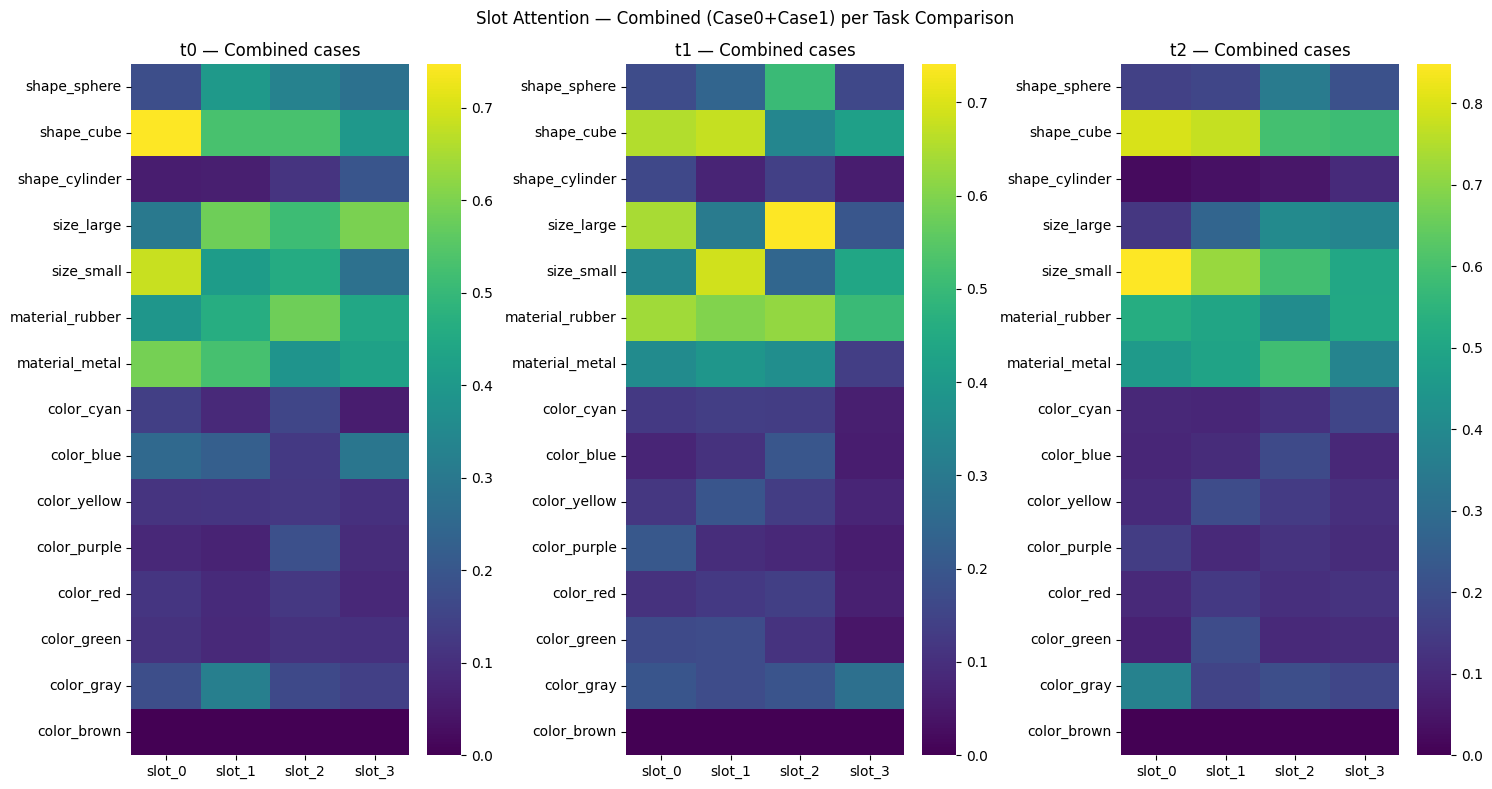

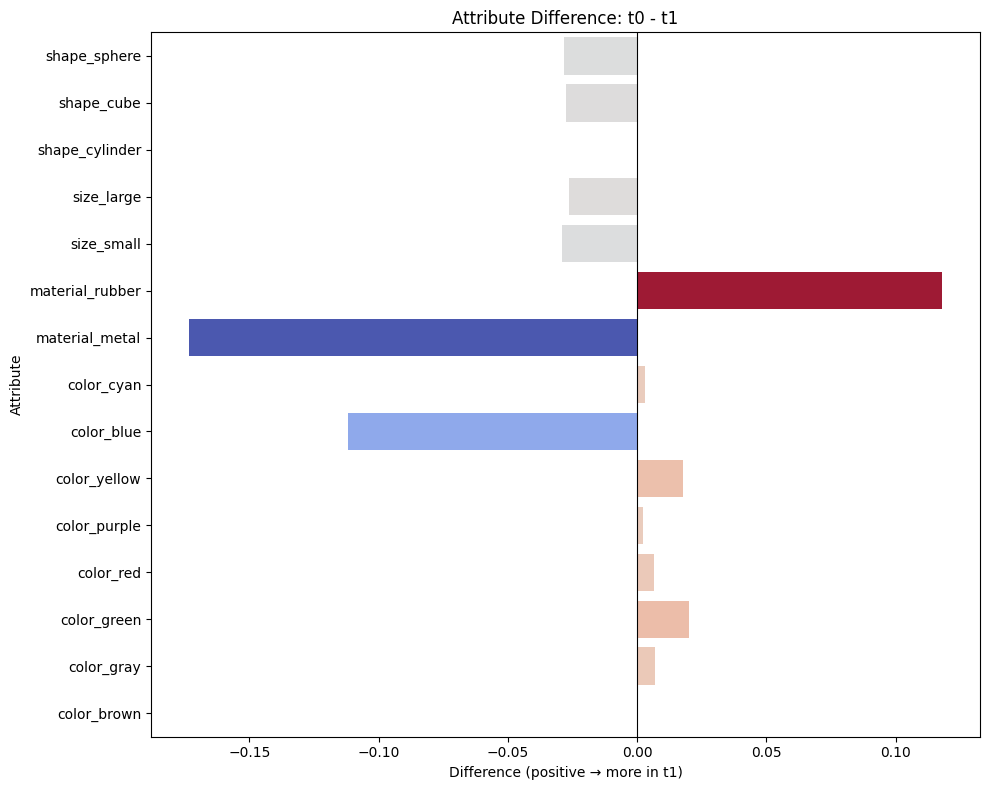

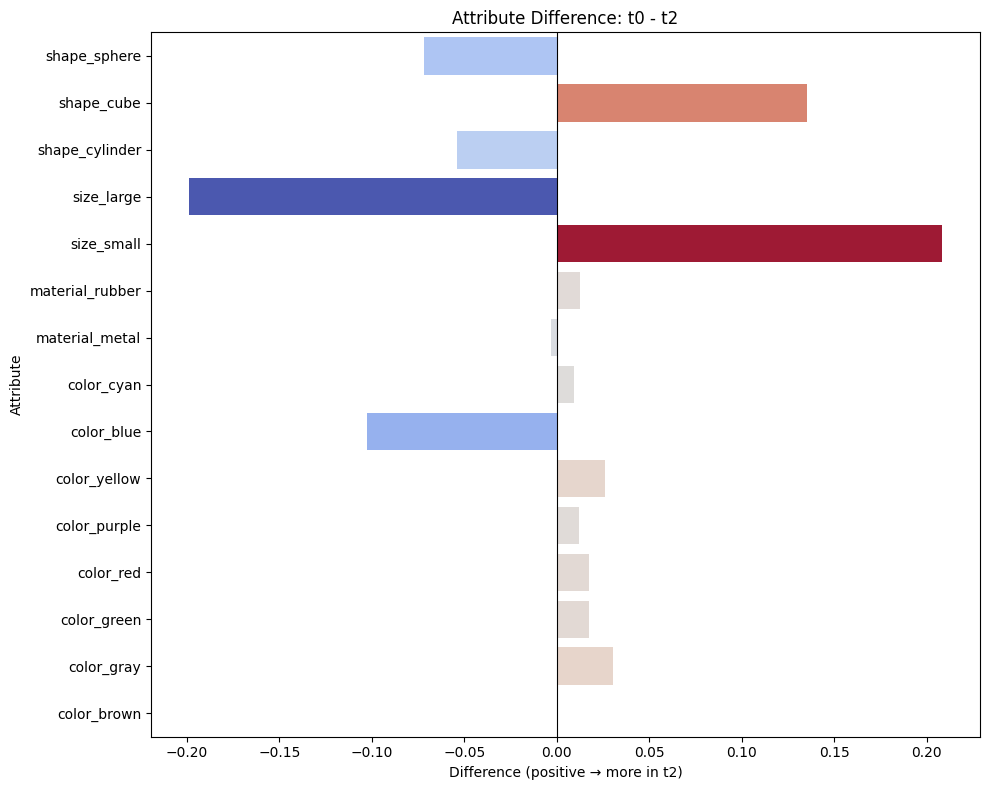

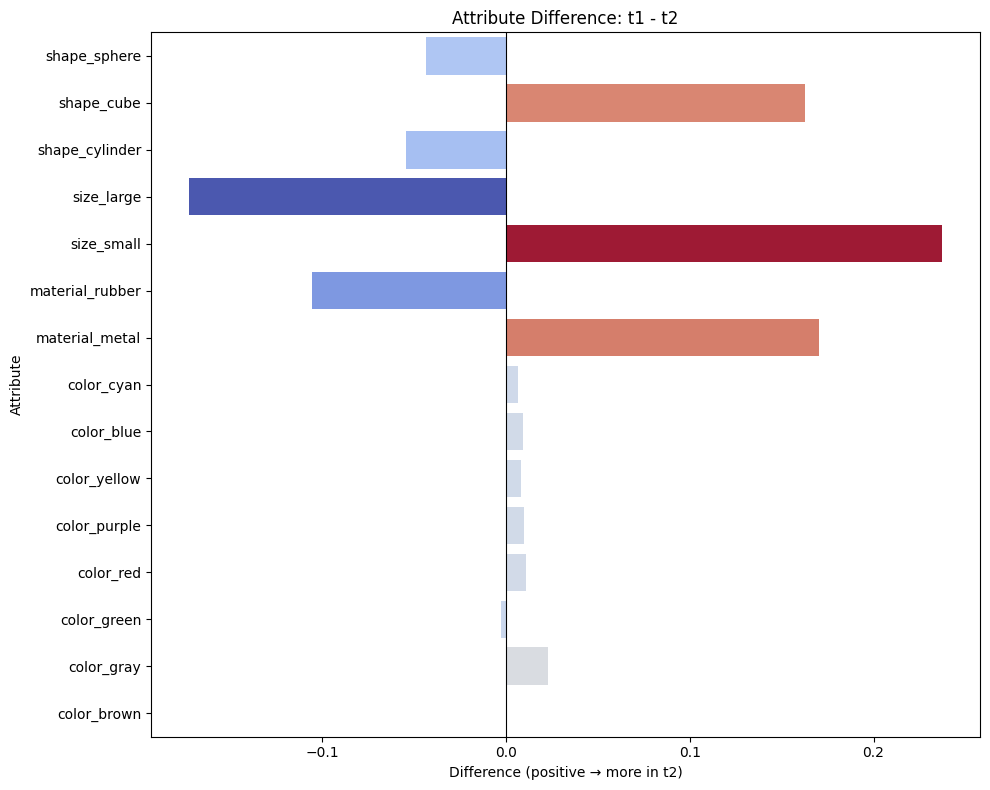

In [36]:
# First combine (case0 + case1) per task
strict_task_combined = {}

for task in tasks:
    key_0 = f"{task}_0"
    key_1 = f"{task}_1"

    merged_0 = strict_accumulator[key_0]
    merged_1 = strict_accumulator[key_1]

    # ✅ Combine via average or sum (choose your method)
    combined = (merged_0 + merged_1) / 2
    strict_task_combined[task] = combined

# ✅ Now compare across tasks
num_tasks = len(tasks)
plt.figure(figsize=(5 * num_tasks, 8))

for i, task in enumerate(tasks):
    combined = strict_task_combined[task]

    plt.subplot(1, num_tasks, i+1)
    sns.heatmap(combined, cmap="viridis", annot=False, cbar=True,
                xticklabels=[f"slot_{j}" for j in range(combined.shape[1])],
                yticklabels=clean_attr_labels)
    plt.title(f"{task} — Combined cases")

plt.suptitle("Slot Attention — Combined (Case0+Case1) per Task Comparison")
plt.tight_layout()
plt.show()


task_pairs = [("t1", "t0"), ("t2", "t0"), ("t2", "t1")]

for (task_a, task_b) in task_pairs:
    # 🔹 Average over slots per task
    mean_a = strict_task_combined[task_a].mean(axis=1)  # [n_attr]
    mean_b = strict_task_combined[task_b].mean(axis=1)

    diff = mean_a - mean_b

    # 🔹 Build dataframe for plotting
    df_diff = pd.DataFrame({
        'Attribute': clean_attr_labels,
        'Difference': diff
    })

    plt.figure(figsize=(10, 8))
    sns.barplot(data=df_diff, x='Difference', y='Attribute',
                palette="coolwarm", hue='Difference', dodge=False)
    plt.title(f"Attribute Difference: {task_b} - {task_a}")
    plt.xlabel(f"Difference (positive → more in {task_a})")
    plt.ylabel("Attribute")
    plt.axvline(0, color='black', linewidth=0.8)
    plt.legend([],[], frameon=False)  # Remove redundant legend
    plt.tight_layout()
    plt.show()

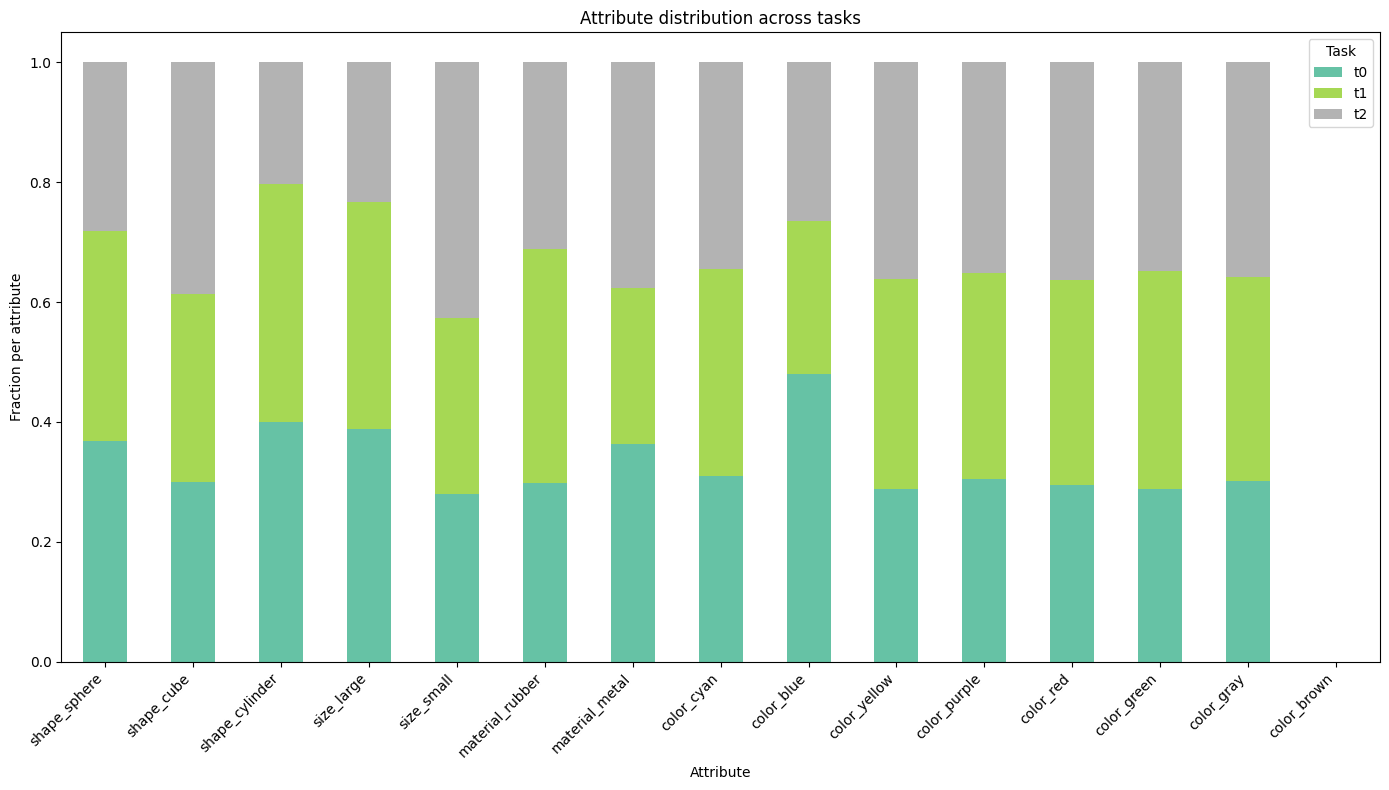

In [24]:

# Build dataframe
task_sums = {}
for task in tasks:
    combined = strict_task_combined[task]
    attr_sum = combined.sum(axis=1)
    task_sums[task] = attr_sum

df = pd.DataFrame(task_sums, index=clean_attr_labels)

# Normalize to fraction per attribute if desired
df_norm = df.div(df.sum(axis=1), axis=0)

# Plot
df_norm.plot(kind="bar", stacked=True, figsize=(14,8), colormap="Set2")
plt.title("Attribute distribution across tasks")
plt.ylabel("Fraction per attribute")
plt.xlabel("Attribute")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Task")
plt.tight_layout()
plt.show()


## Extend slot for unmatch slot (similarity < 0.5 )

In [25]:
def match_slots_extend(new_slots, ref_slots, cleaned_labels, threshold=0.5):
    """
    Matching with dynamic slot extension:
    - Match slots using multiple attribute groups
    - If similarity < threshold, add as new slot (instead of discarding)
    """

    group_idx = [
        i for i, lab in enumerate(cleaned_labels)
        if lab.startswith(('shape_', 'size_', 'material_', 'color_'))
    ]

    A = ref_slots[group_idx, :]  # [n_selected_attr, n_ref_slots]
    B = new_slots[group_idx, :]  # [n_selected_attr, n_new_slots]

    cost = -np.dot(A.T, B)  # negative similarity

    row_ind, col_ind = linear_sum_assignment(cost)
    similarity = -cost[row_ind, col_ind]  # back to positive

    # Initialize with existing ref slots only
    aligned = ref_slots.copy()
    new_slots_to_add = []

    for r, c, sim in zip(row_ind, col_ind, similarity):
        if sim >= threshold:
            # Accept match → overwrite ref slot position
            aligned[:, r] = new_slots[:, c]
        else:
            # Similarity too low → queue this slot to add later
            new_slots_to_add.append(new_slots[:, c])

    # Append unmatched new slots as new columns
    if new_slots_to_add:
        new_slots_to_add = np.stack(new_slots_to_add, axis=1)  # [n_attr, n_new_extended_slots]
        aligned = np.concatenate([aligned, new_slots_to_add], axis=1)

    return aligned


## Intervention algorithm

In [26]:
import torch
import torch.nn as nn
import os

def train_val_test_save_per_attribute_multi_thresholds(
    model_class,
    checkpoint_path,
    slot_attention_weights_path,
    train_loader,
    val_loader_p,
    val_loader_n,
    test_loader_p,
    test_loader_n,
    optimizer_class,
    criterion,
    diff,
    attr_labels,
    thresholds=[-0.1],  # list of thresholds
    device='cuda',
    epochs=10,
    lr=0.001,
    save_dir='./models'
):
    os.makedirs(save_dir, exist_ok=True)
    results_all = {}

    for thresh in thresholds:
        if thresh < 0:
            selected_indices = [i for i, v in enumerate(diff) if v < thresh]
            tag = "neg"
        else:
            selected_indices = [i for i, v in enumerate(diff) if v > thresh]
            tag = "pos"

        selected_names = [attr_labels[i] for i in selected_indices]

        print(f"\n🔎 Threshold {thresh} → Attributes selected: {selected_names}")

        for idx, attr_name in zip(selected_indices, selected_names):
            print(f"\n🔬 Running intervention pipeline for attribute: {attr_name} (diff {diff[idx]:.4f})")

            # ✅ Initialize model
            model = model_class().to(device)
            state_dict = torch.load(checkpoint_path, map_location=device)
            model.load_state_dict(state_dict)
            print(f"✅ Loaded model checkpoint from {checkpoint_path}")

            log = torch.load(slot_attention_weights_path, map_location=device)
            model.img2state_net.load_state_dict(log['weights'], strict=True)
            model = model.to(device)
            model.eval()
            model.img2state_net.eval()
            model.set_cls.train()

            optimizer = optimizer_class(
                [p for name, p in model.named_parameters() if p.requires_grad and 'set_cls' in name],
                lr=lr
            )

            train_acc_list, train_loss_list, val_acc_list = [], [], []

            for epoch in range(epochs):
                model.set_cls.train()
                train_correct, train_loss, counter = 0, 0.0, 0
                torch.set_grad_enabled(True)

                for _, (image, labels) in enumerate(train_loader):
                    counter += 1
                    image, labels = image.to(device), labels.to(device)
                    image = (image - 0.5) * 2.0
                    optimizer.zero_grad()

                    attrs = model.img2state_net(image)
                    attrs_trans = model.img2state_net._transform_attrs(attrs).detach()
                    attrs_trans[:, :, idx] = 0  # 🔧 Intervene only selected attribute

                    outputs = model.set_cls(attrs_trans)
                    loss = criterion(outputs, labels)
                    train_loss += loss.item()
                    _, preds = torch.max(outputs.data, 1)
                    train_correct += (preds == labels).sum().item()

                    loss.backward()
                    optimizer.step()

                avg_train_loss = train_loss / counter
                train_acc = 100. * (train_correct / len(train_loader.dataset))
                train_loss_list.append(avg_train_loss)
                train_acc_list.append(train_acc)

                # ✅ Validation
                model.set_cls.eval()
                val_correct_p, val_correct_n = 0, 0
                torch.set_grad_enabled(False)

                for image, labels in val_loader_p:
                    image, labels = image.to(device), labels.to(device)
                    image = (image - 0.5) * 2.0
                    attrs = model.img2state_net(image)
                    attrs_trans = model.img2state_net._transform_attrs(attrs).detach()
                    attrs_trans[:, :, idx] = 0
                    outputs = model.set_cls(attrs_trans)
                    _, preds = torch.max(outputs.data, 1)
                    val_correct_p += (preds == labels).sum().item()

                for image, labels in val_loader_n:
                    image, labels = image.to(device), labels.to(device)
                    image = (image - 0.5) * 2.0
                    attrs = model.img2state_net(image)
                    attrs_trans = model.img2state_net._transform_attrs(attrs).detach()
                    attrs_trans[:, :, idx] = 0
                    outputs = model.set_cls(attrs_trans)
                    _, preds = torch.max(outputs.data, 1)
                    val_correct_n += (preds == labels).sum().item()

                avg_val_acc = 100. * (val_correct_p + val_correct_n) / (len(val_loader_p.dataset) + len(val_loader_n.dataset))
                val_acc_list.append(avg_val_acc)

                print(f"Epoch {epoch+1}/{epochs} → Train Acc: {train_acc:.2f}%, Val Acc: {avg_val_acc:.2f}%")

            # ✅ Final test
            correct_p, correct_n = 0, 0
            model.set_cls.eval()
            with torch.no_grad():
                for image, labels in test_loader_p:
                    image, labels = image.to(device), labels.to(device)
                    image = (image - 0.5) * 2.0
                    attrs = model.img2state_net(image)
                    attrs_trans = model.img2state_net._transform_attrs(attrs).detach()
                    attrs_trans[:, :, idx] = 0
                    outputs = model.set_cls(attrs_trans)
                    _, preds = torch.max(outputs.data, 1)
                    correct_p += (preds == labels).sum().item()

                for image, labels in test_loader_n:
                    image, labels = image.to(device), labels.to(device)
                    image = (image - 0.5) * 2.0
                    attrs = model.img2state_net(image)
                    attrs_trans = model.img2state_net._transform_attrs(attrs).detach()
                    attrs_trans[:, :, idx] = 0
                    outputs = model.set_cls(attrs_trans)
                    _, preds = torch.max(outputs.data, 1)
                    correct_n += (preds == labels).sum().item()

            acc_p = 100. * correct_p / len(test_loader_p.dataset)
            acc_n = 100. * correct_n / len(test_loader_n.dataset)
            avg_test_acc = (acc_p + acc_n) / 2

            print(f"✅ Final test result → {attr_name} ({tag}) → Pos Acc: {acc_p:.2f}%, Neg Acc: {acc_n:.2f}%, Avg: {avg_test_acc:.2f}%")

            # ✅ Save model with task + attr + tag
            base_name = os.path.basename(checkpoint_path)
            task_name = base_name.replace("model_", "").replace(".pt", "")
            save_path = os.path.join(save_dir, f"model_{task_name}_{attr_name}_{tag}.pt")
            torch.save(model.state_dict(), save_path)

            # ✅ Print save path for clarity
            print(f"💾 Saved model → {save_path}")

            results_all[f"{attr_name}_{tag}"] = {
                "train_acc": train_acc_list,
                "train_loss": train_loss_list,
                "val_acc": val_acc_list,
                "test_acc": avg_test_acc
            }

    return results_all


In [27]:


def train_val_test_save_per_named_interventions(
    model_class,
    checkpoint_path,
    slot_attention_weights_path,
    train_loader,
    val_loader_p,
    val_loader_n,
    test_loader_p,
    test_loader_n,
    unconf_test_loader_p,
    unconf_test_loader_n,
    optimizer_class,
    criterion,
    attr_labels,
    intervention_maps,
    device='cuda',
    epochs=10,
    lr=0.001,
    save_dir='./models'
):
    os.makedirs(save_dir, exist_ok=True)
    results_all = {}

    for map_idx, attr_names in enumerate(intervention_maps):
        attr_names = sorted(attr_names)
        attr_indices = [attr_labels.index(name) for name in attr_names]
        tag = f"custom{map_idx}"
        print(f"\n🔬 Running intervention pipeline for attributes: {attr_names} (indices: {attr_indices})")

        model = model_class().to(device)
        model.load_state_dict(torch.load(checkpoint_path, map_location=device))
        model.img2state_net.load_state_dict(torch.load(slot_attention_weights_path, map_location=device)['weights'])
        model.eval()
        model.img2state_net.eval()
        model.set_cls.train()

        optimizer = optimizer_class(
            [p for name, p in model.named_parameters() if p.requires_grad and 'set_cls' in name],
            lr=lr
        )
                # ** this is the key addition **
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer,
            T_max=epochs,       # one “anneal cycle” over all epochs
            eta_min=1e-6        # same as original
        )

        train_acc_list, train_loss_list, val_acc_list = [], [], []
        unconf_acc_epoch_log = []

        for epoch in range(epochs):
            model.set_cls.train()
            train_correct, train_loss, counter = 0, 0.0, 0
            torch.set_grad_enabled(True)

            for _, (image, labels) in enumerate(train_loader):
                counter += 1
                image, labels = image.to(device), labels.to(device)
                image = (image - 0.5) * 2.0
                optimizer.zero_grad()

                attrs = model.img2state_net(image)
                attrs_trans = model.img2state_net._transform_attrs(attrs).detach()
                if attrs_trans.shape[2] != len(attr_labels):
                    print(f"⚠️  Train attr count mismatch: {attrs_trans.shape[2]} vs {len(attr_labels)}")
                    continue
                for idx in attr_indices:
                    attrs_trans[:, :, idx] = 0

                outputs = model.set_cls(attrs_trans)
                loss = criterion(outputs, labels)
                train_loss += loss.item()
                _, preds = torch.max(outputs.data, 1)
                train_correct += (preds == labels).sum().item()
                loss.backward()
                optimizer.step()
            scheduler.step()
            avg_train_loss = train_loss / counter
            train_acc = 100. * (train_correct / len(train_loader.dataset))
            train_loss_list.append(avg_train_loss)
            train_acc_list.append(train_acc)

            model.set_cls.eval()
            val_correct_p, val_correct_n = 0, 0
            torch.set_grad_enabled(False)

            for image, labels in val_loader_p:
                image, labels = image.to(device), labels.to(device)
                image = (image - 0.5) * 2.0
                attrs = model.img2state_net(image)
                attrs_trans = model.img2state_net._transform_attrs(attrs)
                if attrs_trans.shape[2] != len(attr_labels):
                    continue
                for idx in attr_indices:
                    attrs_trans[:, :, idx] = 0
                outputs = model.set_cls(attrs_trans)
                _, preds = torch.max(outputs.data, 1)
                val_correct_p += (preds == labels).sum().item()

            for image, labels in val_loader_n:
                image, labels = image.to(device), labels.to(device)
                image = (image - 0.5) * 2.0
                attrs = model.img2state_net(image)
                attrs_trans = model.img2state_net._transform_attrs(attrs)
                if attrs_trans.shape[2] != len(attr_labels):
                    continue
                for idx in attr_indices:
                    attrs_trans[:, :, idx] = 0
                outputs = model.set_cls(attrs_trans)
                _, preds = torch.max(outputs.data, 1)
                val_correct_n += (preds == labels).sum().item()

            avg_val_acc = 100. * (val_correct_p + val_correct_n) / (len(val_loader_p.dataset) + len(val_loader_n.dataset))
            val_acc_list.append(avg_val_acc)

            print(f"Epoch {epoch+1}/{epochs} → Train Acc: {train_acc:.2f}%, Val Acc: {avg_val_acc:.2f}%")

            # 🔍 Unconfounded test set evaluation
            correct_up, correct_un = 0, 0
            with torch.no_grad():
                for image, labels in unconf_test_loader_p:
                    image, labels = image.to(device), labels.to(device)
                    image = (image - 0.5) * 2.0
                    attrs = model.img2state_net(image)
                    attrs_trans = model.img2state_net._transform_attrs(attrs)
                    if attrs_trans.shape[2] != len(attr_labels):
                        continue
                    for idx in attr_indices:
                        attrs_trans[:, :, idx] = 0
                    outputs = model.set_cls(attrs_trans)
                    _, preds = torch.max(outputs.data, 1)
                    correct_up += (preds == labels).sum().item()

                for image, labels in unconf_test_loader_n:
                    image, labels = image.to(device), labels.to(device)
                    image = (image - 0.5) * 2.0
                    attrs = model.img2state_net(image)
                    attrs_trans = model.img2state_net._transform_attrs(attrs)
                    if attrs_trans.shape[2] != len(attr_labels):
                        continue
                    for idx in attr_indices:
                        attrs_trans[:, :, idx] = 0
                    outputs = model.set_cls(attrs_trans)
                    _, preds = torch.max(outputs.data, 1)
                    correct_un += (preds == labels).sum().item()

            unconf_acc_p = 100. * correct_up / len(unconf_test_loader_p.dataset)
            unconf_acc_n = 100. * correct_un / len(unconf_test_loader_n.dataset)
            unconf_acc_avg = (unconf_acc_p + unconf_acc_n) / 2
            unconf_acc_epoch_log.append({
                "epoch": epoch + 1,
                "acc_p": unconf_acc_p,
                "acc_n": unconf_acc_n,
                "acc_avg": unconf_acc_avg
            })

            print(f"🧪 Unconf Test Acc (Epoch {epoch+1}) → Pos: {unconf_acc_p:.2f}%, Neg: {unconf_acc_n:.2f}%, Avg: {unconf_acc_avg:.2f}%")

        # ✅ Final test
        correct_p, correct_n = 0, 0
        with torch.no_grad():
            for loader, counter in zip([test_loader_p, test_loader_n], [correct_p, correct_n]):
                for image, labels in loader:
                    image, labels = image.to(device), labels.to(device)
                    image = (image - 0.5) * 2.0
                    attrs = model.img2state_net(image)
                    attrs_trans = model.img2state_net._transform_attrs(attrs)
                    if attrs_trans.shape[2] != len(attr_labels):
                        continue
                    for idx in attr_indices:
                        attrs_trans[:, :, idx] = 0
                    outputs = model.set_cls(attrs_trans)
                    _, preds = torch.max(outputs.data, 1)
                    if loader is test_loader_p:
                        correct_p += (preds == labels).sum().item()
                    else:
                        correct_n += (preds == labels).sum().item()

        acc_p = 100. * correct_p / len(test_loader_p.dataset)
        acc_n = 100. * correct_n / len(test_loader_n.dataset)
        avg_test_acc = (acc_p + acc_n) / 2
        print(f"✅ Final test result → {attr_names} → Pos Acc: {acc_p:.2f}%, Neg Acc: {acc_n:.2f}%, Avg: {avg_test_acc:.2f}%")

        base_name = os.path.basename(checkpoint_path)
        task_name = base_name.replace("model_", "").replace(".pt", "")
        attr_tag = "_".join(attr_names)
        save_path = os.path.join(save_dir, f"model_{task_name}_{attr_tag}_{tag}.pt")
        torch.save(model.state_dict(), save_path)
        print(f"💾 Saved model → {save_path}")

        results_all[f"{attr_tag}_{tag}"] = {
            "train_acc": train_acc_list,
            "train_loss": train_loss_list,
            "val_acc": val_acc_list,
            "test_acc": avg_test_acc,
            "unconf_test_per_epoch": unconf_acc_epoch_log  # ✅ included here
        }

    return results_all


In [28]:


def train_val_test_save_per_named_interventions(
    model_class,
    checkpoint_path,
    slot_attention_weights_path,
    train_loader,
    val_loader_p,
    val_loader_n,
    test_loader_p,
    test_loader_n,
    unconf_test_loader_p,
    unconf_test_loader_n,
    optimizer_class,
    criterion,
    attr_labels,
    intervention_maps,
    device='cuda',
    epochs=10,
    lr=0.001,
    save_dir='./models'
):
    os.makedirs(save_dir, exist_ok=True)
    results_all = {}

    for map_idx, attr_names in enumerate(intervention_maps):
        attr_names = sorted(attr_names)
        attr_indices = [attr_labels.index(name) for name in attr_names]
        tag = f"custom{map_idx}"
        print(f"\n🔬 Running intervention pipeline for attributes: {attr_names} (indices: {attr_indices})")

        model = model_class().to(device)
        model.load_state_dict(torch.load(checkpoint_path, map_location=device))
        model.img2state_net.load_state_dict(torch.load(slot_attention_weights_path, map_location=device)['weights'])
        model.eval()
        model.img2state_net.eval()
        model.set_cls.train()

        optimizer = optimizer_class(
            [p for name, p in model.named_parameters() if p.requires_grad and 'set_cls' in name],
            lr=lr
        )
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-6)

        train_acc_list, train_loss_list, val_acc_list,train_acc_step_log = [], [], [],[]
        unconf_acc_epoch_log = []
        unconf_acc_step_log = []
        running_correct = 0
        running_total = 0
        image_seen = 0  # Initialize counter outside the epoch loop
        for epoch in range(epochs):
            model.set_cls.train()
            train_correct, train_loss, counter = 0, 0.0, 0
            torch.set_grad_enabled(True)

            for batch_idx, (image, labels) in enumerate(train_loader):
                counter += 1
                image, labels = image.to(device), labels.to(device)
                image = (image - 0.5) * 2.0
                optimizer.zero_grad()

                attrs = model.img2state_net(image)
                attrs_trans = model.img2state_net._transform_attrs(attrs).detach()

                if attrs_trans.shape[2] != len(attr_labels):
                    print(f"⚠️  Train attr count mismatch: {attrs_trans.shape[2]} vs {len(attr_labels)}")
                    continue

                for idx in attr_indices:
                    attrs_trans[:, :, idx] = 0

                outputs = model.set_cls(attrs_trans)
                loss = criterion(outputs, labels)
                train_loss += loss.item()
                _, preds = torch.max(outputs.data, 1)
                train_correct += (preds == labels).sum().item()
                loss.backward()
                optimizer.step()

                image_seen += image.size(0)
                running_correct += (preds == labels).sum().item()
                running_total += labels.size(0)

                # 🔎 Training acc logging
                if image_seen % 100 == 0:
                    acc_step = 100. * running_correct / running_total
                    train_acc_step_log.append({
                        "image_seen": image_seen,
                        "acc": acc_step
                    })

                # 🧪 Evaluate unconf every 1000 images
                if image_seen % 100 == 0:
                    up, un, avg = evaluate_unconf(
                        model,
                        unconf_test_loader_p,
                        unconf_test_loader_n,
                        attr_indices,
                        attr_labels,
                        device
                    )
                    unconf_acc_step_log.append({
                        "image_seen": image_seen,
                        "acc_p": up,
                        "acc_n": un,
                        "acc_avg": avg
                    })

            scheduler.step()
            avg_train_loss = train_loss / counter
            train_acc = 100. * (train_correct / len(train_loader.dataset))
            train_loss_list.append(avg_train_loss)
            train_acc_list.append(train_acc)

            val_acc_p, val_acc_n, avg_val_acc = validate(model, val_loader_p, val_loader_n, attr_indices, attr_labels, device)
            val_acc_list.append({
                "epoch": epoch + 1,
                "acc_p": val_acc_p,
                "acc_n": val_acc_n,
                "acc_avg": avg_val_acc
            })

            print(f"Epoch {epoch+1}/{epochs} → Train Acc: {train_acc:.2f}%, Val Acc: {avg_val_acc:.2f}%")

            unconf_acc_p, unconf_acc_n, unconf_acc_avg = evaluate_unconf(
                model,
                unconf_test_loader_p,
                unconf_test_loader_n,
                attr_indices,
                attr_labels,
                device
            )
            unconf_acc_epoch_log.append({
                "epoch": epoch + 1,
                "acc_p": unconf_acc_p,
                "acc_n": unconf_acc_n,
                "acc_avg": unconf_acc_avg
            })

            print(f"🧪 Unconf Test Acc (Epoch {epoch+1}) → Pos: {unconf_acc_p:.2f}%, Neg: {unconf_acc_n:.2f}%, Avg: {unconf_acc_avg:.2f}%")

        acc_p, acc_n, avg_test_acc = evaluate_test(
            model,
            test_loader_p,
            test_loader_n,
            attr_indices,
            attr_labels,
            device
        )
        print(f"✅ Final test result → {attr_names} → Pos Acc: {acc_p:.2f}%, Neg Acc: {acc_n:.2f}%, Avg: {avg_test_acc:.2f}%")

        base_name = os.path.basename(checkpoint_path)
        task_name = base_name.replace("model_", "").replace(".pt", "")
        attr_tag = "_".join(attr_names)
        save_path = os.path.join(save_dir, f"model_{task_name}_{attr_tag}_{tag}.pt")
        torch.save(model.state_dict(), save_path)
        print(f"💾 Saved model → {save_path}")

        results_all[f"{attr_tag}_{tag}"] = {
            "train_acc": train_acc_list,
            "train_loss": train_loss_list,
            "val_acc": val_acc_list,
            "test_acc": avg_test_acc,
            "unconf_test_per_epoch": unconf_acc_epoch_log,
            "unconf_test_stepwise": unconf_acc_step_log,
            "train_acc_stepwise": train_acc_step_log
        }

    return results_all
#latest 17/7 11:15

In [29]:
def train_val_test_save_per_attribute_multi_thresholds(
    model_class,
    checkpoint_path,
    slot_attention_weights_path,
    train_loader,
    val_loader_p,
    val_loader_n,
    test_loader_p,
    test_loader_n,
    optimizer_class,
    criterion,
    diff,
    attr_labels,
    thresholds=[-0.1],
    device='cuda',
    epochs=10,
    lr=0.001,
    save_dir='./models'
):
    os.makedirs(save_dir, exist_ok=True)
    results_all = {}

    for thresh in thresholds:
        tag = "neg" if thresh < 0 else "pos"
        selected_indices = [i for i, v in enumerate(diff) if (v < thresh if tag == "neg" else v > thresh)]
        selected_names = [attr_labels[i] for i in selected_indices]

        print(f"\n🔎 Threshold {thresh} → Attributes selected: {selected_names}")

        for idx, attr_name in zip(selected_indices, selected_names):
            print(f"\n🔬 Running intervention pipeline for attribute: {attr_name} (diff {diff[idx]:.4f})")

            model = model_class().to(device)
            state_dict = torch.load(checkpoint_path, map_location=device)
            model.load_state_dict(state_dict)
            log = torch.load(slot_attention_weights_path, map_location=device)
            model.img2state_net.load_state_dict(log['weights'], strict=True)
            model.eval()
            model.img2state_net.eval()
            model.set_cls.train()

            optimizer = optimizer_class(
                [p for name, p in model.named_parameters() if p.requires_grad and 'set_cls' in name],
                lr=lr
            )

            train_acc_list, train_loss_list, val_acc_list = [], [], []

            for epoch in range(epochs):
                train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, idx, device)
                val_acc = validate_one_epoch(model, val_loader_p, val_loader_n, criterion, idx, device)

                train_loss_list.append(train_loss)
                train_acc_list.append(train_acc)
                val_acc_list.append(val_acc)

                print(f"Epoch {epoch+1}/{epochs} → Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")

            acc_p, acc_n, avg_test_acc = test_model(model, test_loader_p, test_loader_n, idx, device)

            print(f"✅ Final test result → {attr_name} ({tag}) → Pos Acc: {acc_p:.2f}%, Neg Acc: {acc_n:.2f}%, Avg: {avg_test_acc:.2f}%")

            base_name = os.path.basename(checkpoint_path)
            task_name = base_name.replace("model_", "").replace(".pt", "")
            save_path = os.path.join(save_dir, f"model_{task_name}_{attr_name}_{tag}.pt")
            torch.save(model.state_dict(), save_path)
            print(f"💾 Saved model → {save_path}")

            results_all[f"{attr_name}_{tag}"] = {
                "train_acc": train_acc_list,
                "train_loss": train_loss_list,
                "val_acc": val_acc_list,
                "test_acc": avg_test_acc
            }

    return results_all
